# TP 5 : Analyse cepstrale
# le 11/06/2024

Le but de ce TP est d'apprendre à extraire des caractéristiques spectrales du
signal de la parole en vue de l'utilisation dans un système de
reconnaissance automatique.  Nous utiliserons la technique de
l'*analyse cepstrale* (prononcé [ana’liz kεps’t ɾal]).

## 0. Préparation
- Lire le sujet de ce TP et préparer des questions, si besoin.
- Réviser le filtrage RII et RIF.
- Analyser le code de la section I.

## I. Les données
Vous utiliserez des signaux comme ceux enregistrés
dans le TP05, en les faisant passer par l'algorithme de détection de
début/fin de mot.  Voici une manière d'extraire la partie pertinente des
signaux des voyelles, disponibles sur Claroline :

In [12]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# copier-coller ici les fonctions windowing, root_mean_square, zero_crossing et endpoint_detection du TP précédent

def windowing (signal, sample_rate, width, overlap):
    
    Ntotal = signal.shape[0]
    # Convertion la largeur de la fenêtre et le recouvrement en nombre d'échantillons
    N_width = int(width * sample_rate) 
    
     #taille du pas entre chaque fenêtre en fonction de la largeur de la fenêtre et du recouvrement
    N_overlap = int(N_width*(1-overlap))  #taille fenêtre avec overlap
    
    # Calcul du nombre total de fenêtre 
    nb_fenetre = (Ntotal - N_width) // N_overlap + 1
    
    # Initialisation une matrice pour contenir les fenêtres
    windows = np.zeros((nb_fenetre,N_width))
    
    for i in range(nb_fenetre):
        debut = i*N_overlap
        windows[i, :]=signal[ debut : debut + N_width ] # extraction des valeurs de la fenetre i
    
        
    return windows

def root_mean_square(windows):
    if not(np.isreal(windows).all()) or np.ndim(windows) != 2:
        print("Argument must be a 2D array containing real numbers")
    else:
        return np.sqrt(np.mean(windows**2, 1))


def zero_crossing(windows):
    if not(np.isreal(windows).all()) or np.ndim(windows) != 2:
        print("Argument must be a 2D array containing real numbers")
        return None

    nrow = windows.shape[0]
    zc = np.zeros(nrow)
    for i in range(nrow):
        zc[i] = np.sum(np.diff(np.sign(windows[i, :])) != 0)
    return zc

###
def endpoint_detection(filename, trms, tzc, twmin, tsmax, offset=0):
    sample_rate, signal = wavfile.read(filename)
    width = 0.04
    overlap = 0.75
    lag = (1 - overlap) * width
    ns = len(signal)
    t1 = np.arange(ns) / sample_rate
    windows = windowing (signal + offset, sample_rate, width, overlap)
    nr = windows.shape[0]
    t2 = np.arange(nr) * lag + width / 2
    rms = root_mean_square(windows)
    zc = zero_crossing(windows)

    has_signal = (rms > trms) + (zc > tzc)

    state = 0
    points = []

    for i in range(nr):
        if state == 0:
            if has_signal[i]:
                state = 1
                start_word = i
        elif state == 1:
            if not has_signal[i]:
                state = 2
                start_silence = i
            else:
                if i == nr:
                    points.append([start_word, i]);
        else:
            if not has_signal[i]:
                if i == nr-1 or (i - start_silence) * lag > tsmax:
                    if (start_silence - start_word) * lag > twmin:
                        points.append([start_word, start_silence])
                    state = 0
            else:
                state = 1

    points = width / 2 + np.array(points) * lag

    plt.figure(figsize=(9, 6))
    tlim = [0, max(t1)]
    plt.subplot(3, 1, 1)
    plt.plot(t1, signal, "b", label="signal")
    plt.title(filename)
    plt.xlim(0, np.max(t1))
    ylim = plt.ylim()

    for i in range(points.shape[0]):
        if i > 0:
            plt.plot([points[i,0], points[i, 0]], ylim, "r")
        else:
            plt.plot([points[i,0], points[i, 0]], ylim, "r", label="endpoints")
        plt.plot([points[i,1], points[i, 1]], ylim, "r")
    plt.legend(loc="upper right")
    plt.ylim(ylim)

    plt.subplot(3, 1, 2)
    plt.plot(t2, rms, "b", label="RMS")
    plt.plot(tlim, [trms, trms], "r", label="threshold")
    plt.xlim(tlim)
    plt.legend(loc="upper right")

    plt.subplot(3, 1, 3)
    plt.plot(t2, zc, "b", label="zero crossing")
    plt.plot(tlim, [tzc, tzc], "r", label="threshold")
    plt.xlim(tlim)
    plt.legend(loc="upper right")
    plt.xlabel("time (s)")
    
    return points

<IPython.core.display.Javascript object>


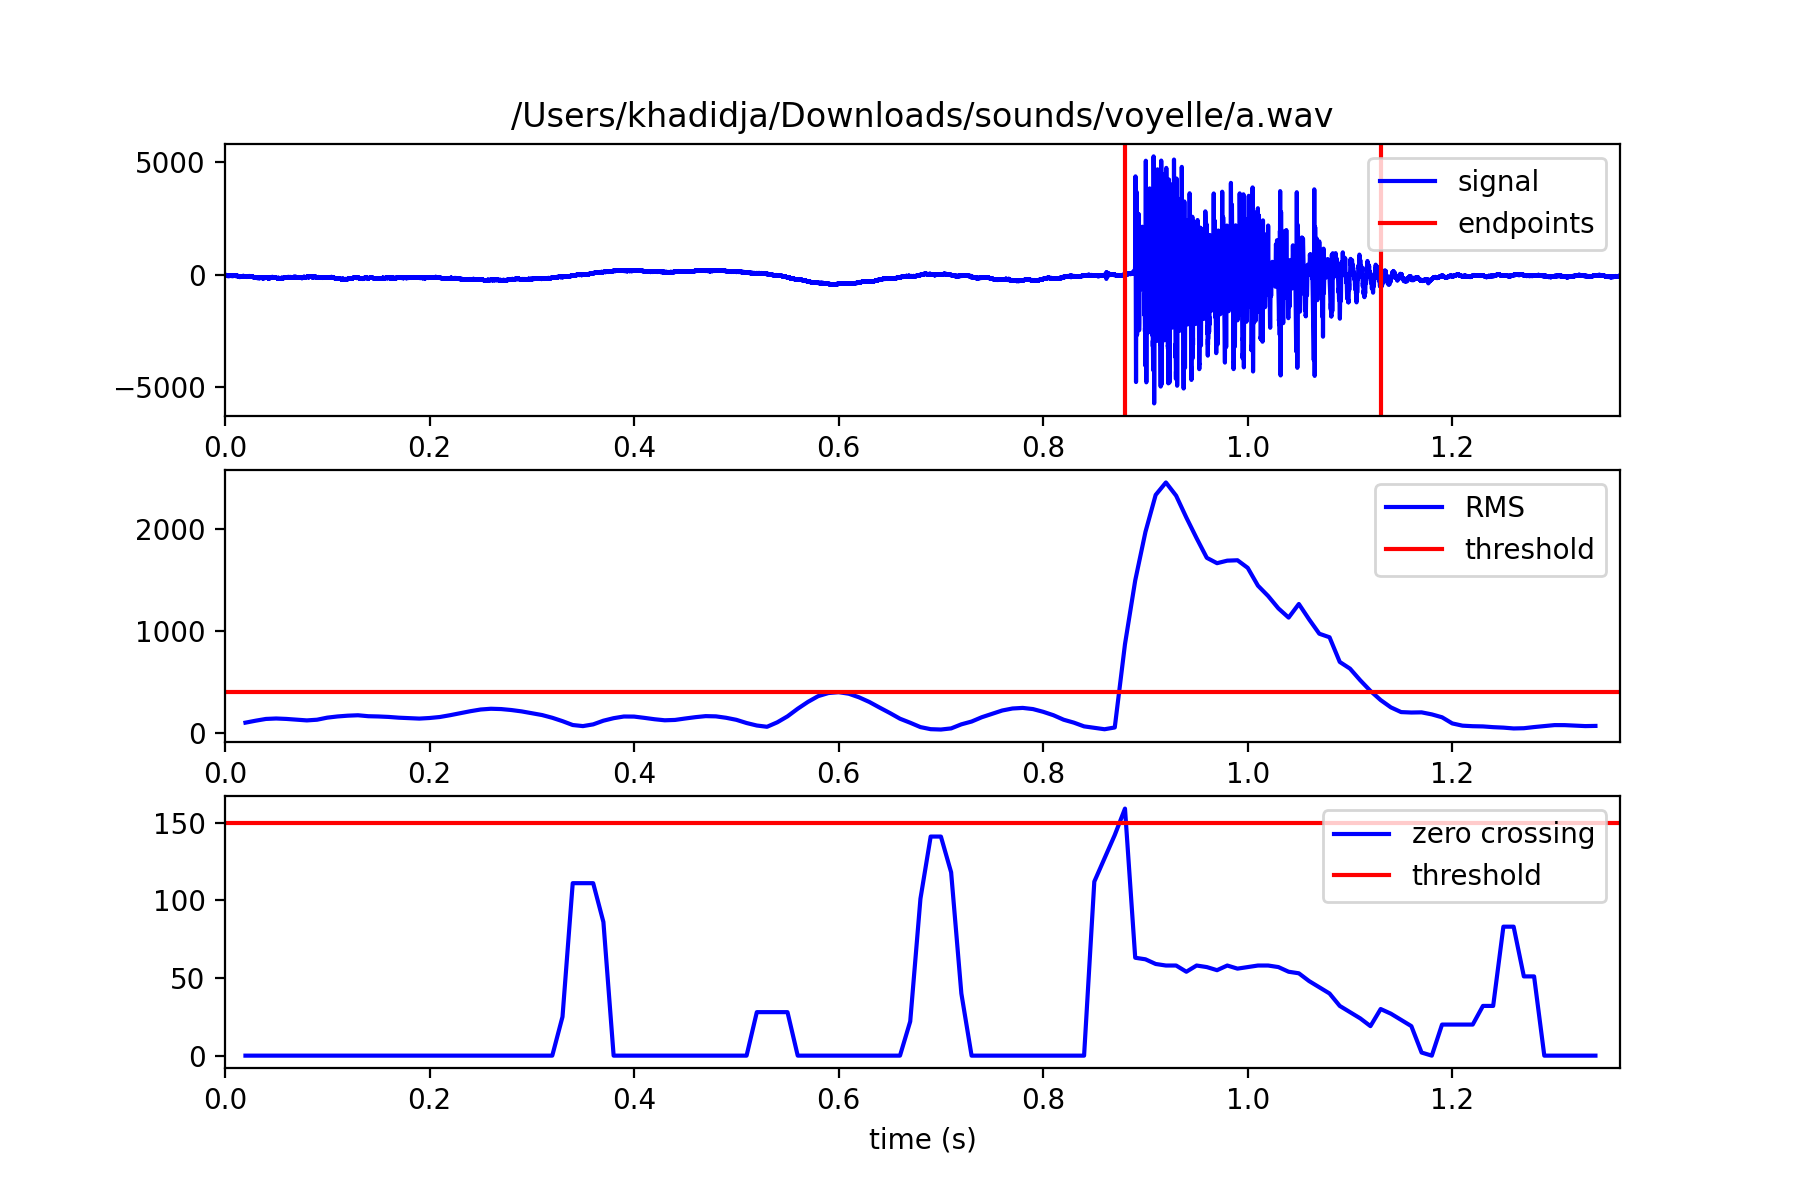

<IPython.core.display.Javascript object>


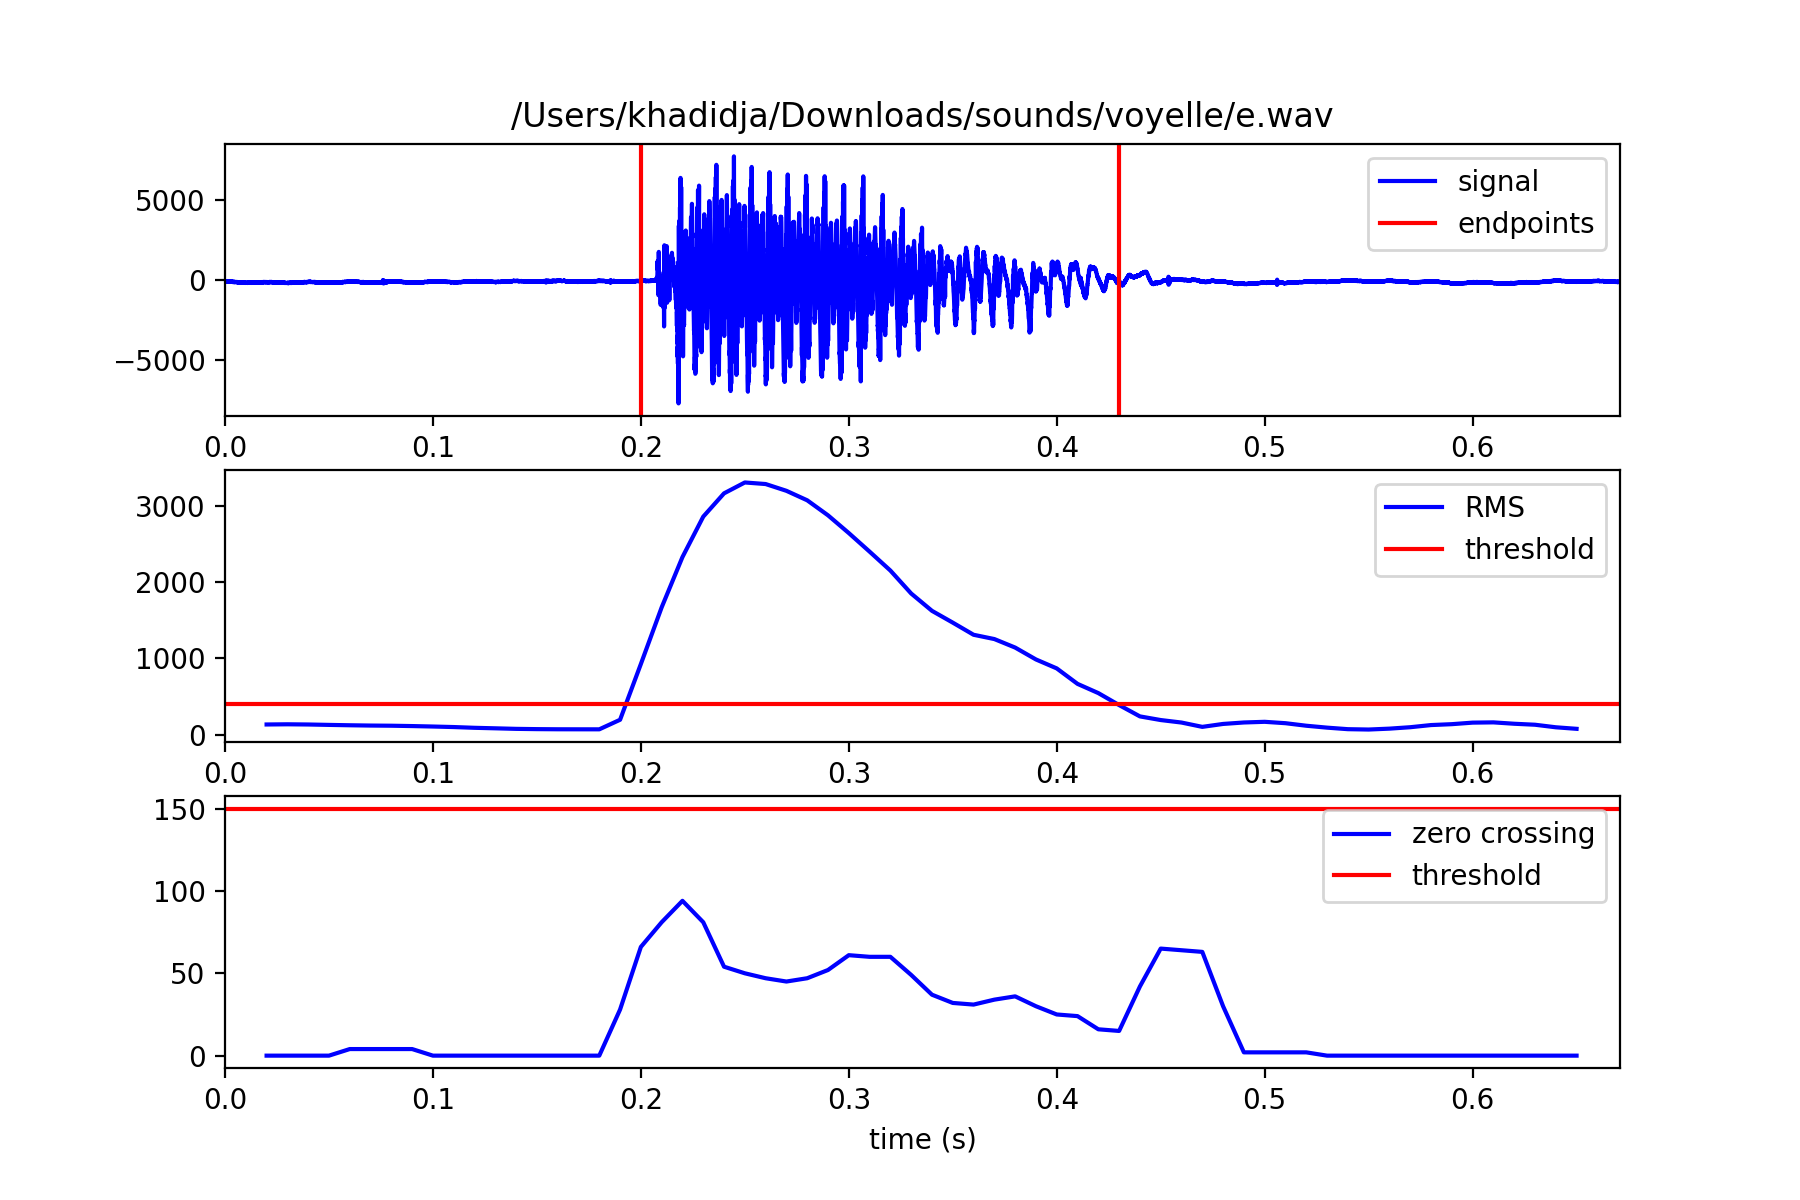

<IPython.core.display.Javascript object>


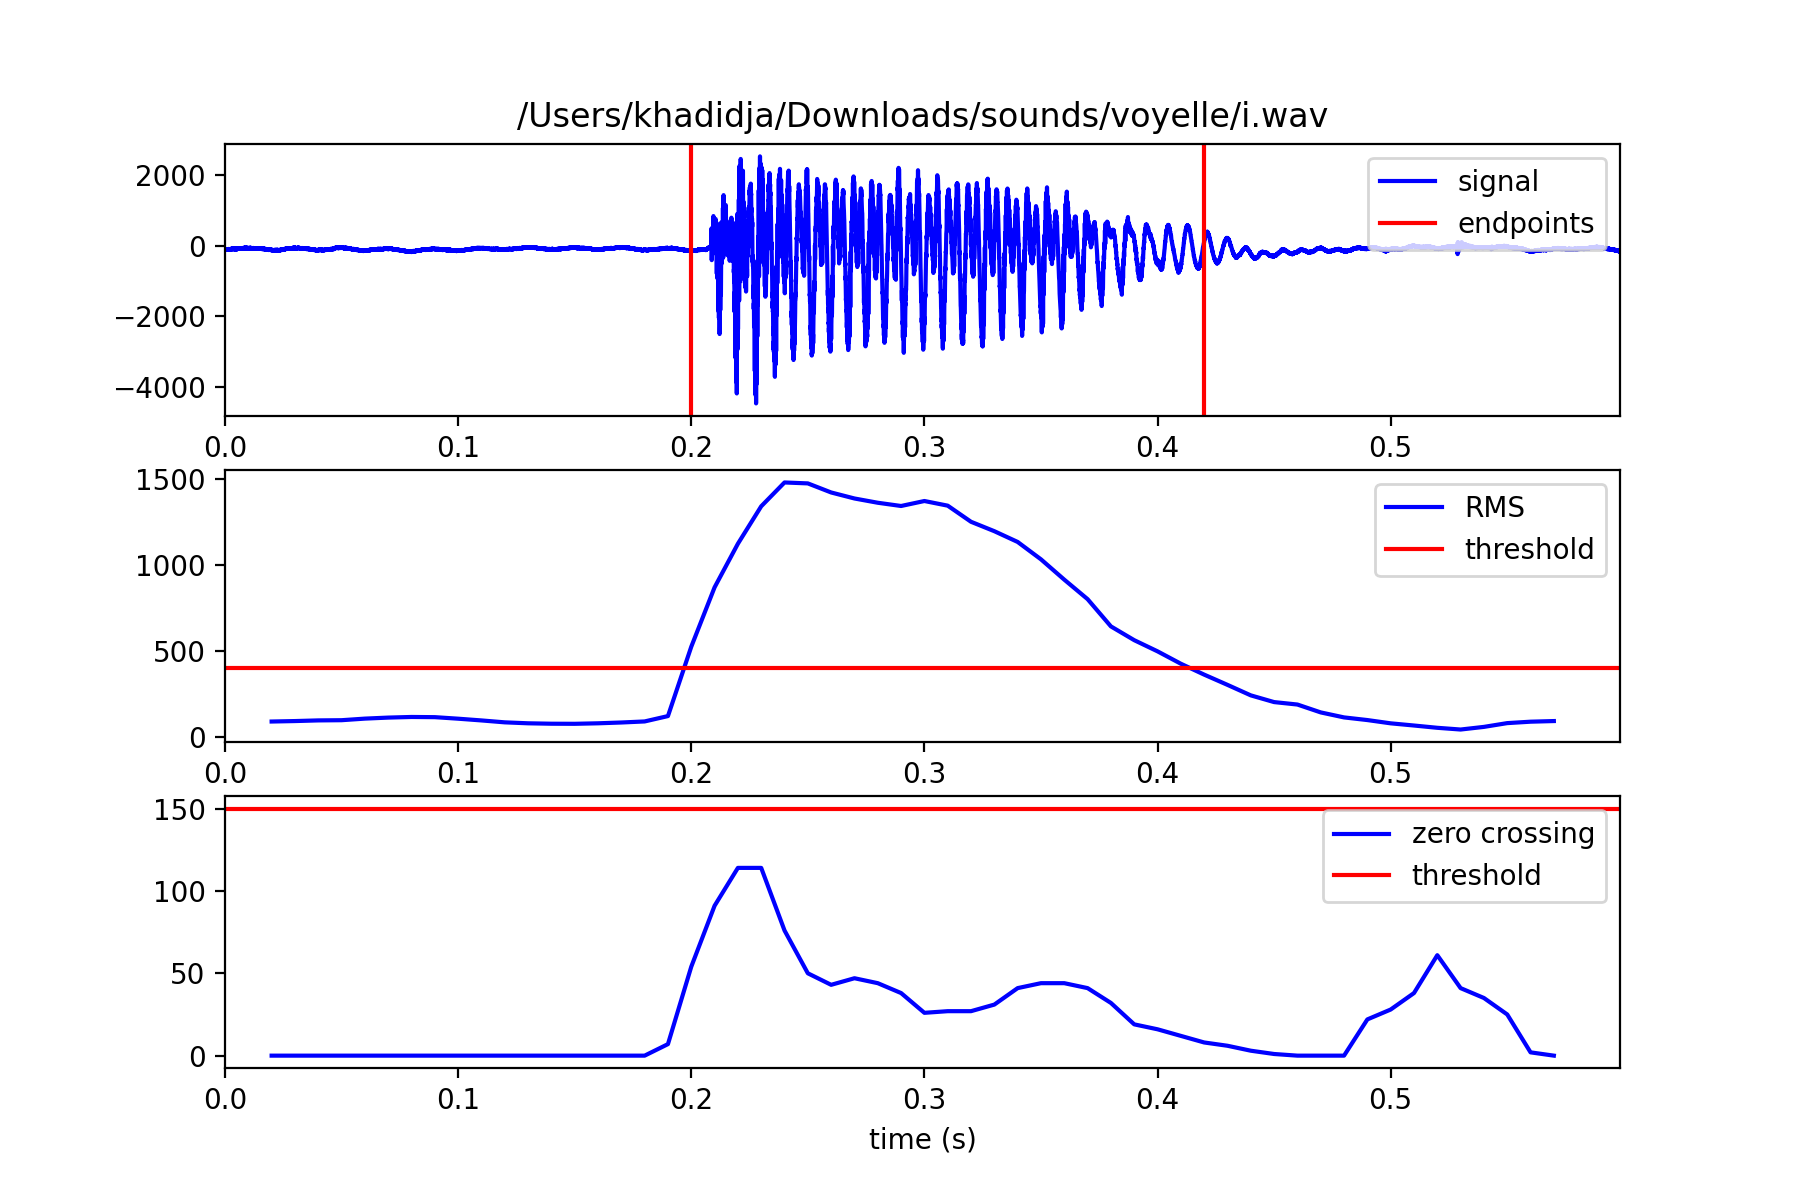

<IPython.core.display.Javascript object>


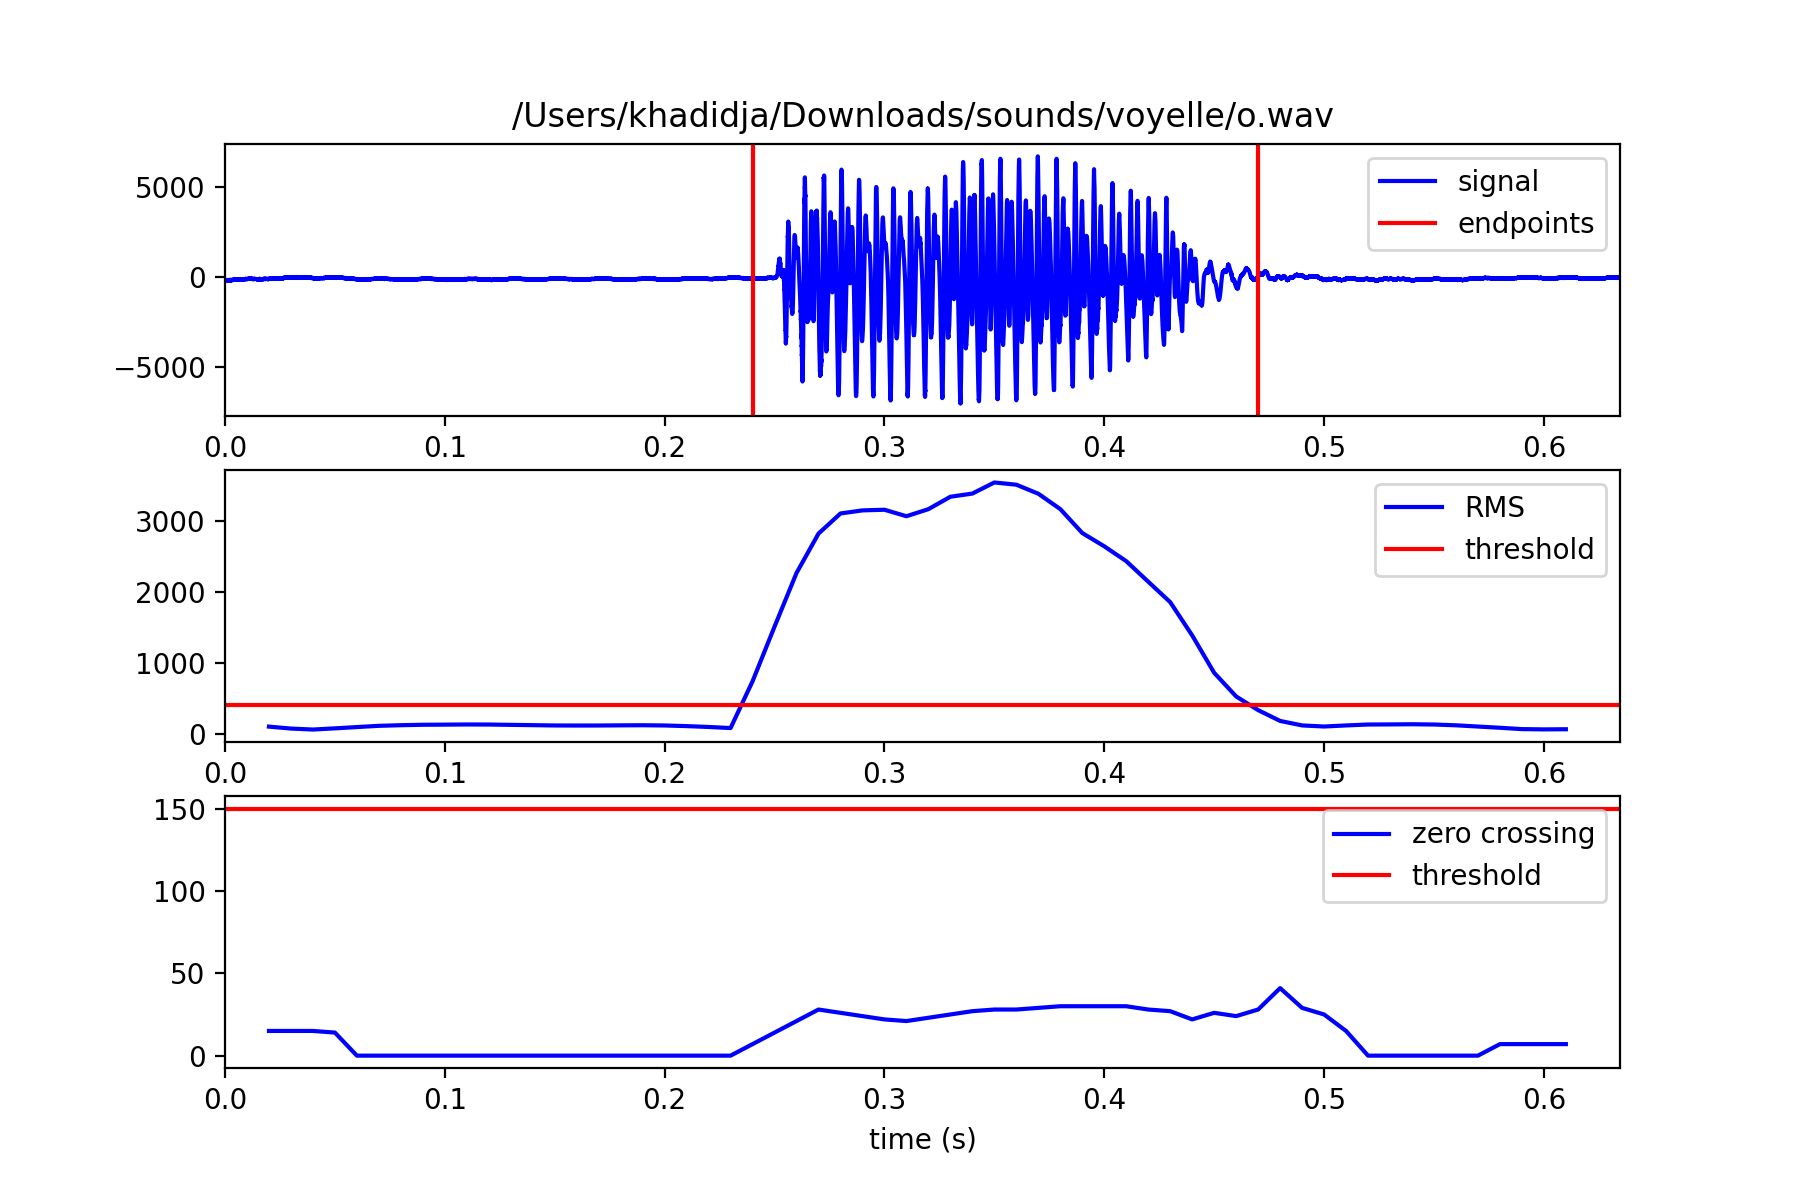

<IPython.core.display.Javascript object>


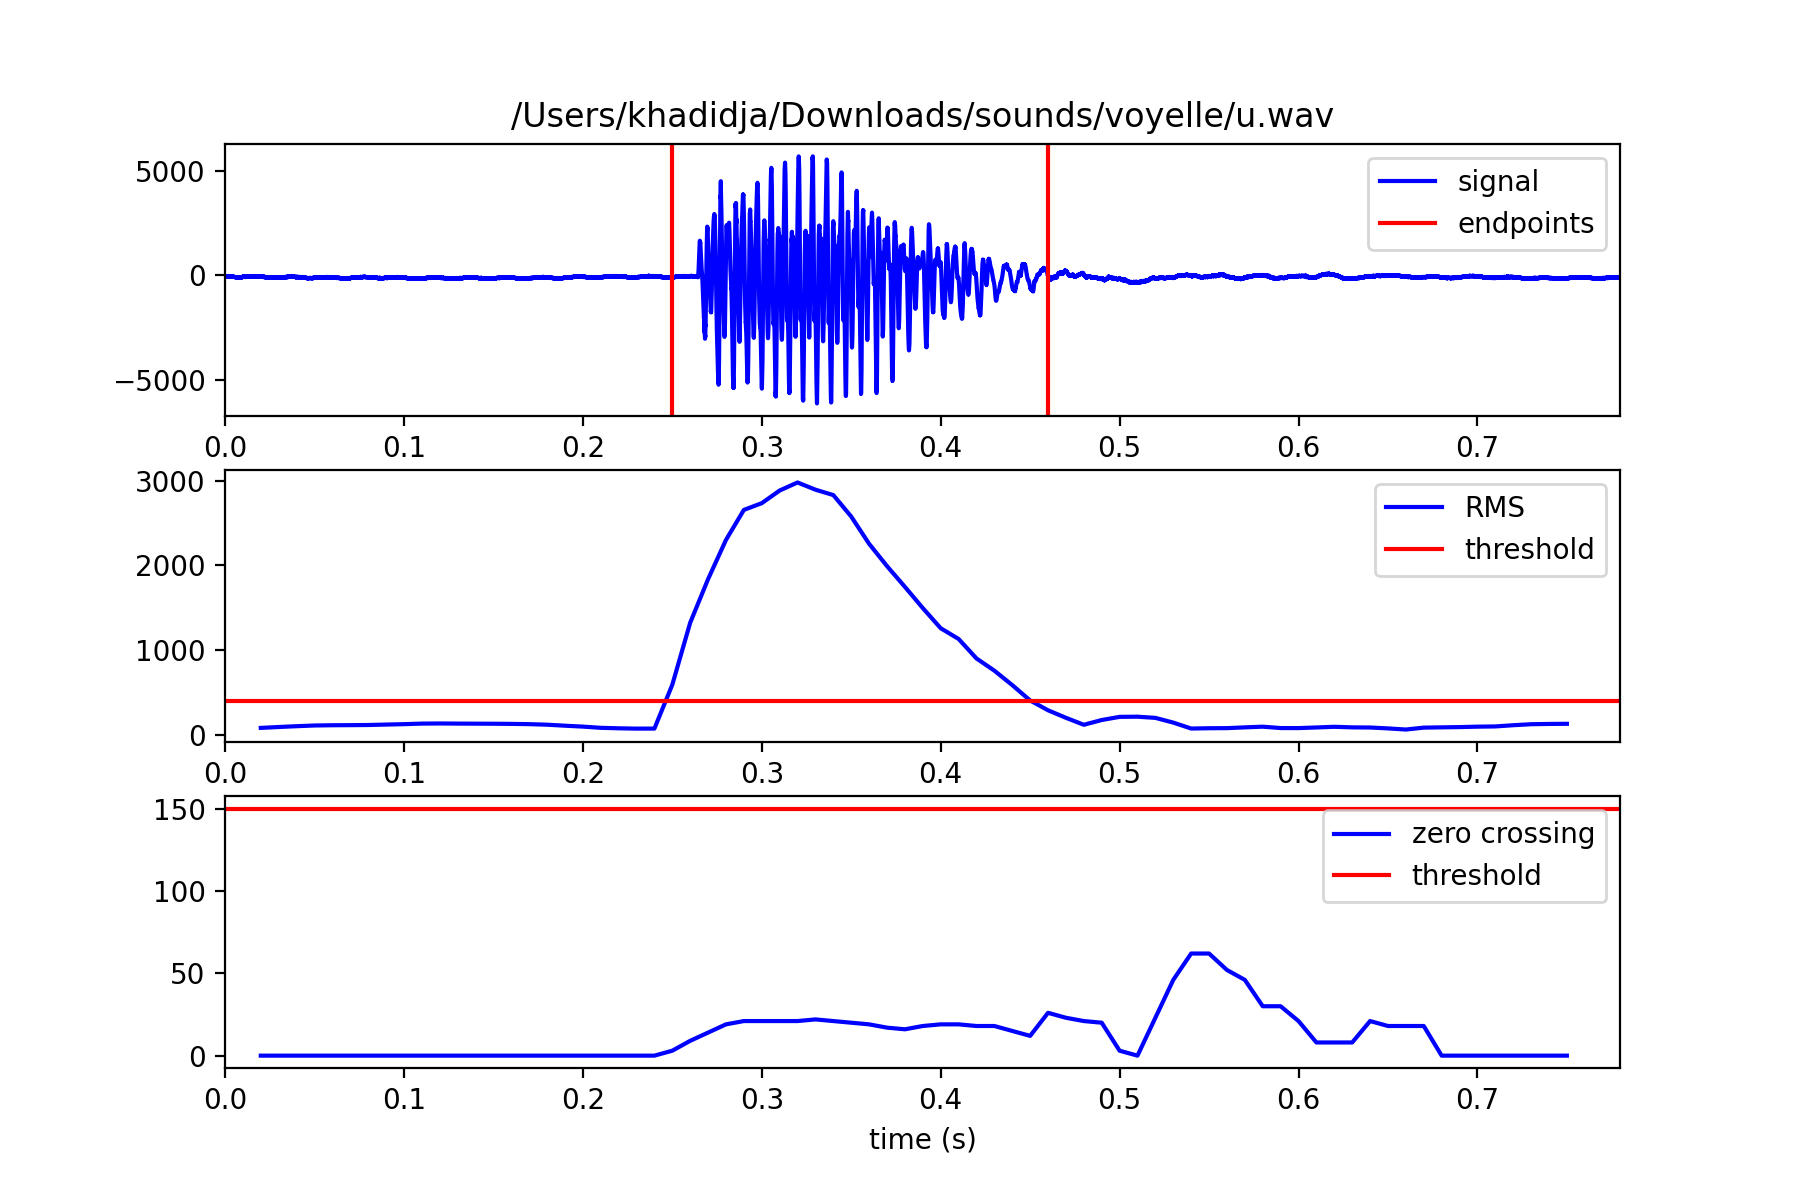

In [13]:
directory = "/Users/khadidja/Downloads/sounds/voyelle/" #répértoire contenant les audios qui seront utilisés
trms = 400 #seuil de RMS
tzc = 150 #seuil du zéro crossing
twmin = 0.2 #durée minimale pour considérer un silence 
tsmax = 0.01 #durée maximale pour considérer un silence

#boucle pour traiter les voyelles. 
for v in ["a", "e", "i", "o", "u"]:

    filename = directory + v + ".wav"
    points = endpoint_detection(filename, trms, tzc, twmin, tsmax) #application de la fontion endpoint pour récupérer les points de débuts et de fin
    #n_start et n_end.
    sample_rate, signal = wavfile.read(filename) #récupère la fréquence d'échantillonnage et le signal de chaque audio 
    n_start = np.int32(points[0, 0] * sample_rate)
    n_end = np.int32(points[0, 1] * sample_rate) 
    signal = signal[n_start:n_end] 
    #au final avec le tableau point on peut extraire la partie du signal audio qui nous interesse.
    with open(v + ".wav", "wb") as f:
        wavfile.write(f, sample_rate, signal)

Ce code charge les signaux des voyelles isolées /a/, /e/, /i/, /o/ et /u/ fournis par sounds.tgz, détecte la partie pertinente du signal à l'aide de la fonction *endpoint_detection* et sauve le signal ainsi réduit dans des fichiers locaux de même nom.

## II. Pré-emphase
Pour compenser la pente spectrale décroissante du
spectre de la parole (due au signal source glottique), nous allons
appliquer un filtre de pré-emphase défini par :

\begin{eqnarray*}
\textrm{fonction de transfert :   } &&
H(z) = \frac{Y(z)}{X(z)} = \frac{1}{1 + \alpha z^{-1}}\\
\textrm{filtre numérique :    } &&
y[n] = x[n] - \alpha y[n-1]
\end{eqnarray*}
avec le coefficient $\alpha$ ayant une valeur entre 0,90 et 0,95,
typiquement.

1. Affichez la réponse en fréquence de ce filtre de la manière suivante
(définissez avant la variable *alpha*) :

<IPython.core.display.Javascript object>


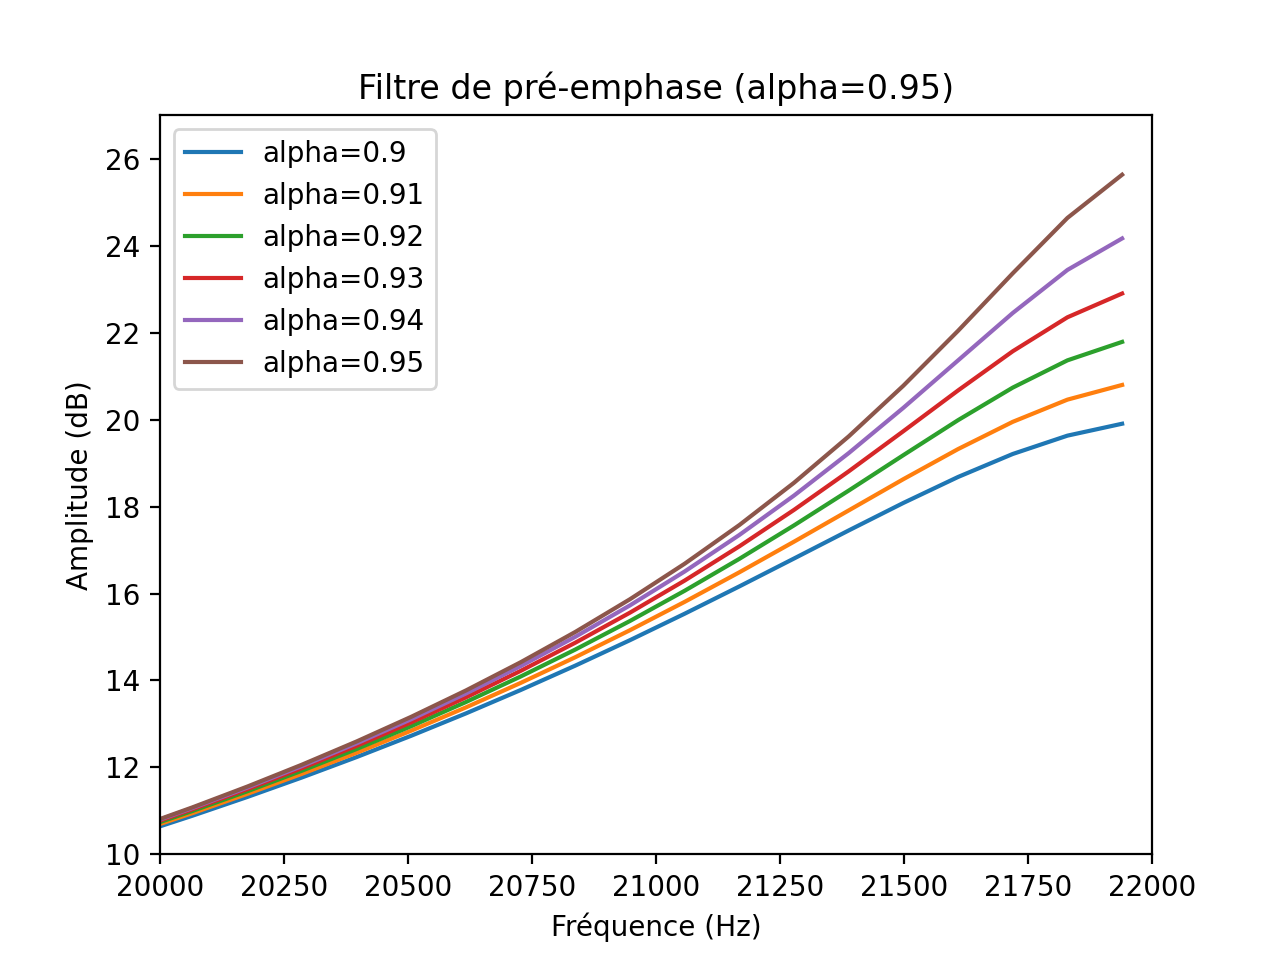

In [22]:
from scipy import signal
plt.figure()

alpha = [0.90,0.91,0.92,0.93,0.94,0.95]

for i in alpha :
    B = [1] #numérateur du filtre
    A = [1, i] #dénominateur du filtre
    F, H = signal.freqz(B, A, 200, fs=sample_rate) #renvoie les fréquences auxquels H a été calculé dans les mêmes unités que fs et 
    
    plt.plot(F, 20 * np.log10(abs(H)),label=f'alpha={i}')
    plt.title(f"Filtre de pré-emphase (alpha={i})")
    plt.xlim([20000,22000])
    plt.ylim([10,27])
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.legend()  
    plt.grid()


In [75]:
signal.freqz?

**2. Interprétez le graphique.  Quel est l'effet du coefficient $\alpha$ ?**

L'effet n'est pas observable pour les basses fréquences. Cependant, pour les hautes fréquences (F > 20000 Hz), on observe que plus le coefficient alpha augmente, plus l'amplitude en dB augmente également. Un alpha plus élevé entraîne l'amplification du gain pour les hautes fréquences.

**3. Filtrez le signal comme dans le code ci-dessous (la fonction *signal.filtfilt* permet un filtrage sans distorsion de phase), affichez et interprétez le résultat.**

In [74]:
signal.filtfilt?

<IPython.core.display.Javascript object>


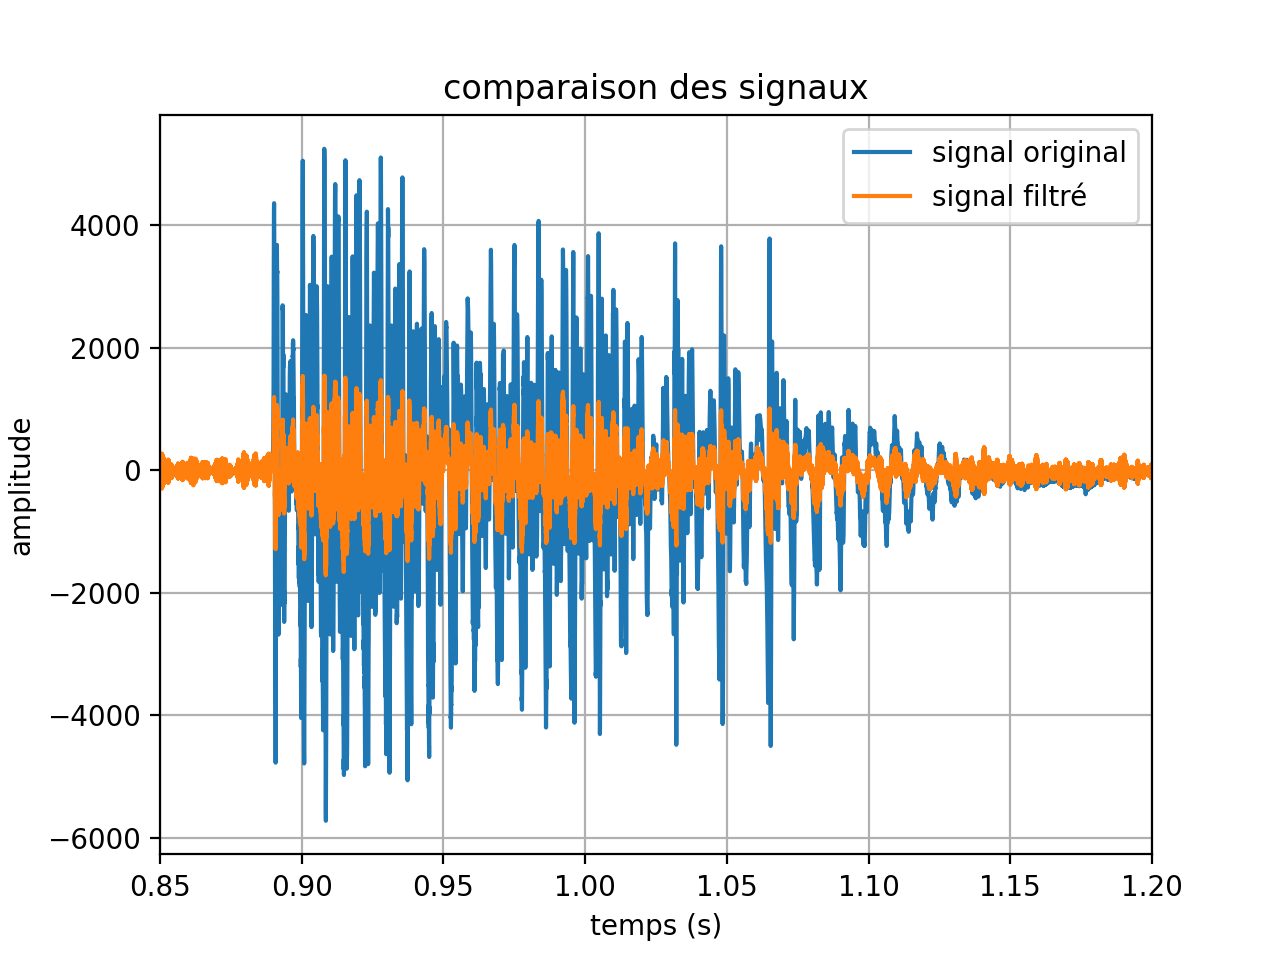

60154 
 60154


In [44]:
sample_rate, sig = wavfile.read("/Users/khadidja/Downloads/sounds/a.wav")
filtered_sig = signal.filtfilt(B, A, sig) #cette fonction applique un filtre dans les deux sens sans déphasage dans la direction directe et inverse
n = len(sig) 
t1 = np.arange(n) / sample_rate 

plt.figure()
plt.plot(t1, sig, label="signal original")
plt.plot(t1, filtered_sig, label="signal filtré")
plt.title("comparaison des signaux")
plt.xlim([0.85, 1.2])
plt.xlabel("temps (s)")
plt.ylabel('amplitude')
plt.grid()
plt.legend()
print(len(filtered_sig), "\n", len(sig))

Le signal.filtfilt permet d'annuler le déphasage induit lors de l'application d'un filtre dans une direction en filtrant une fois dans le sens direct puis inverse. 
Cela nous permet donc d'observer d'observer le signal filtré sans décalage. 

On observe que les hautes fréquences du signal ont été attenuées, le filtre agissant comme un passe-bas.

## III. Fonction de fenêtrage
Après découpage du signal filtré en
fenêtres (avec la fonction *windowing*), nous appliquons une fonction
de fenêtrage pour atténuer les effets de bord.  On utilise couramment en
parole la fonction de Hamming, dont la courbe peut être visualisée grâce à *signal.windows.hamming* :

In [59]:
N = 100
h = signal.windows.hamming(N)
width = 0.04
overlap = 0.75
fenetre_sig=windowing(filtered_sig, sample_rate, width, overlap)

Pour appliquer cette fonction de fenêtrage à chaque extrait du signal filtré, vous utiliserez la fonction *Hamming* donnée ci-dessous.

<IPython.core.display.Javascript object>


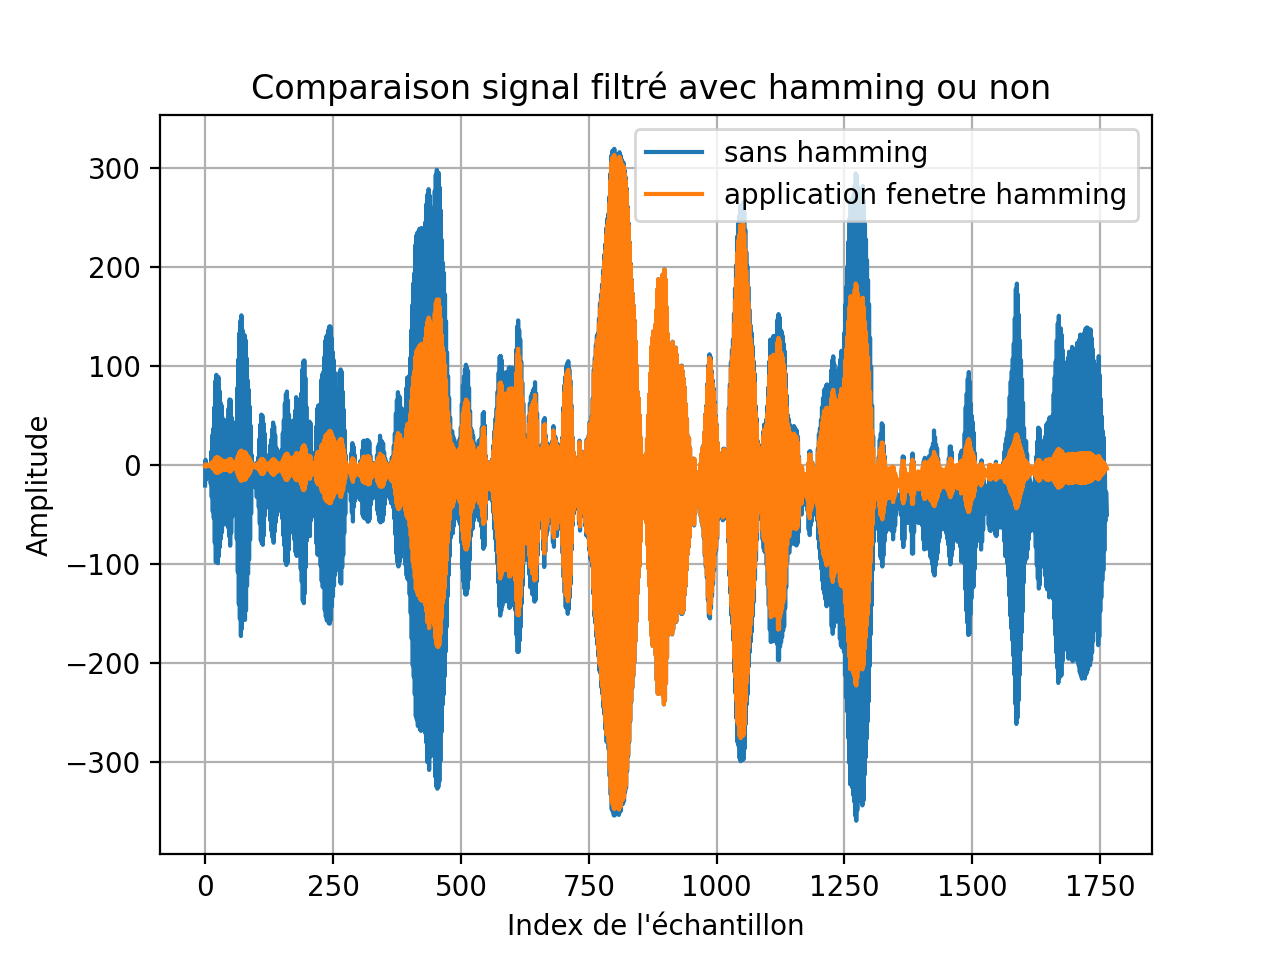

<IPython.core.display.Javascript object>


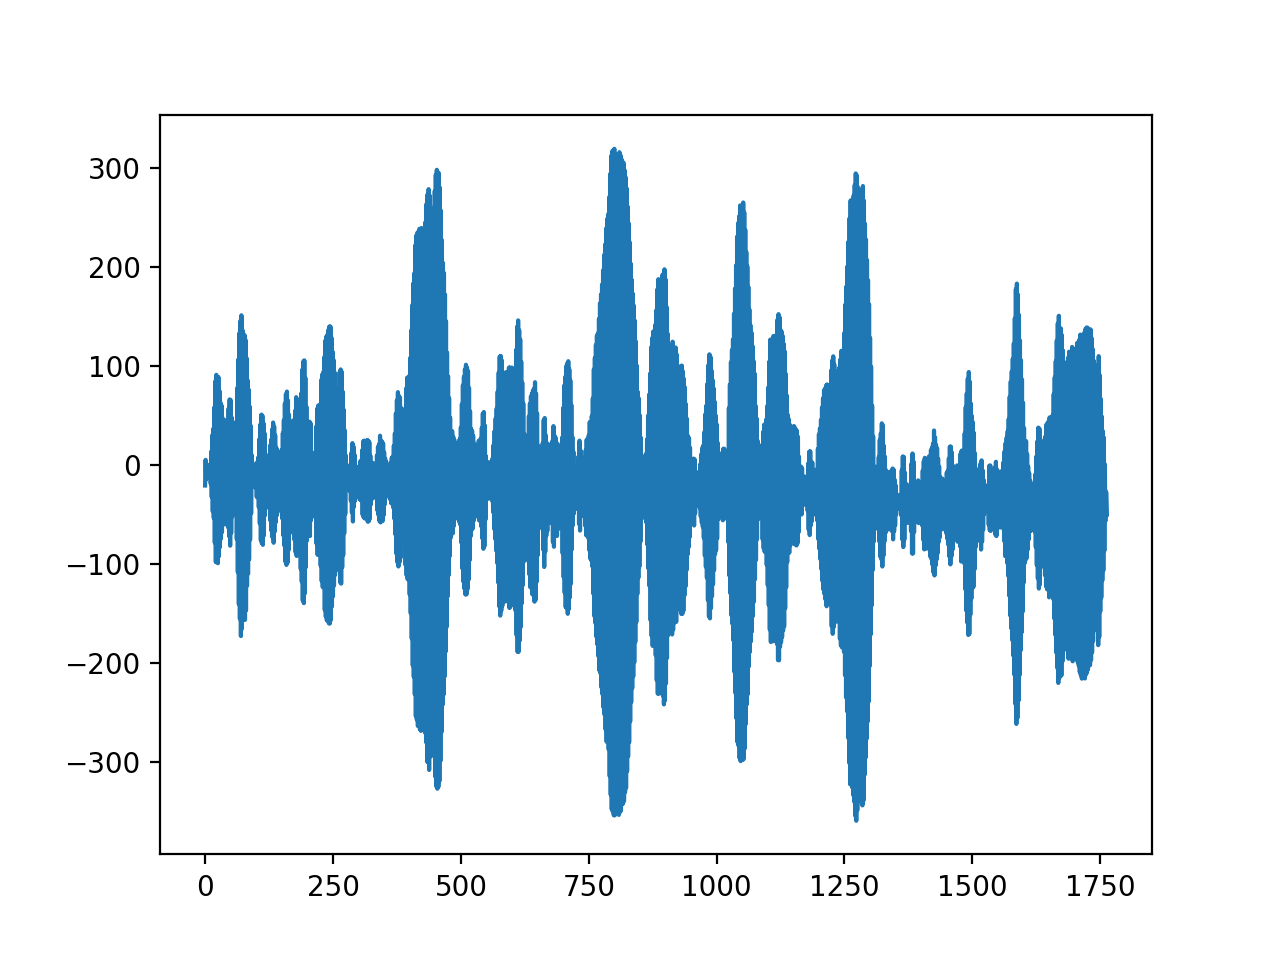

<IPython.core.display.Javascript object>


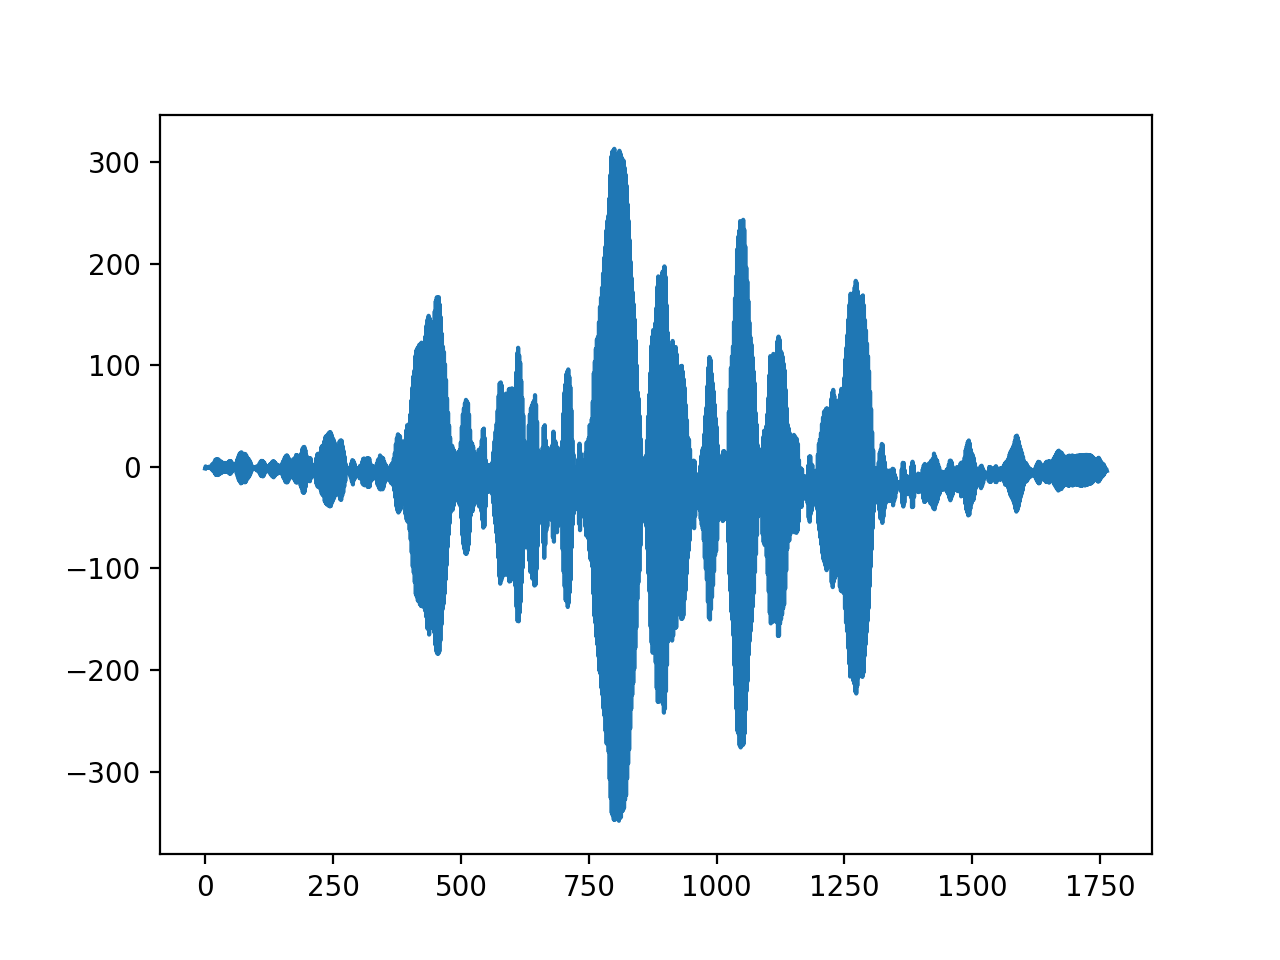

In [60]:
def Hamming(windows):
    nb_rows, nb_cols = windows.shape
    h_windows = np.zeros((nb_rows, nb_cols))
    for idx in range(nb_rows):
        h_windows[idx, :] = windows[idx, :]*signal.windows.hamming(nb_cols)
    return h_windows

ham_filtsig = Hamming(fenetre_sig)

#affichage de la pemière fenetre d'analyse
plt.figure()
plt.plot(fenetre_sig[0], label='sans hamming') 
plt.plot(ham_filtsig[0], label='application fenetre hamming')
plt.title('Comparaison signal filtré avec hamming ou non ')
plt.xlabel('Index de l\'échantillon')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

#je voulais juste afficher les signaux indépendemment
plt.figure()
plt.plot(fenetre_sig[0], label='sans hamming') 
plt.figure()
plt.plot(ham_filtsig[0], label='application fenetre hamming')


1. D'après vous, quel est l'effet de cette opération de fenêtrage ?

In [37]:
width = 0.04
overlap = 0.75
windows = windowing(filtered_sig, sample_rate, width, overlap)
hw = Hamming(windows)

On observe que la fênetre d'hamming attenue l'amplitude du signal à ses extrémités.

Lorsqu'on applique la fonction windowing sur un signal, cela permet d'avoir des fenêtres de celui ci mais cela a aussi pour conséquence de produire des discontinuités entre chaque segmentation du signal ce qui cause des effets de bord et donc des artéfacts au début et fin du signal. Ça peut perturber l'analyse spectrale par la suite. 

L'intérêt d'utiliser une fenêtre de Hamming lors du découpage d'une partie du signal est de minimiser les effets indésirables causés par la discontinuité aux bords du segment du signal. Ça permet d'améliorer la résolution spectrale.

## IV. Analyse cepstrale
L'utilisation du cepstre permet la séparation
entre la source glottique et le filtre associé au conduit vocal.  En
termes mathématiques, le cepstre est défini comme la transformée de
Fourier du logarithme du module de la transformée de Fourier du
signal :

$\mathcal{C}[x(t)] = \mathcal{F}[\log |\mathcal{F}[x(t)]|]$

1. Complétez la fonction *cepstrum* ci-dessous.
Éditez un fichier \verb=cepstrum.m= avec le contenu ci-dessous et complétez
la ligne manquante, selon la formule du cepstre ci-dessus (attention, la matrice retournée par la fonction *cepstrum* doit contenir seulement des valeurs réelles).

In [64]:
def cepstrum(windows):
    """
    Découpe le signal en fenêtres d'analyse de courte durée.
    
    Paramètres
    ----------
    windows: array Numpy à deux dimensions, le nombre de ligne est le nombre de fenêtres découpées,
                                            le nombre de colonnes la largeur d'une fenêtre en points
    Renvoie
    -------
    C: cepstre de chaque fenêtre d'analyse
        array NumPy de *valeurs réelles* à deux dimensions :
            le nombre de ligne est le nombre de fenêtres découpées,
            le nombre de colonnes est le nombre de points d'une autocorrélation
    """
    C = np.zeros(windows.shape)
    for idx in range(windows.shape[0]):
        TF = np.fft.fft(windows[idx, :]) #TF de la fenêtre
        log_tf = np.log(np.abs(TF)) # log du module de la TF
        cepstrum = np.fft.fft(log_tf) # TF du log du module de la TF
        C[idx, :] = cepstrum.real
    return C

Les cepstres peuvent donc être calculés et affichés avec le code
ci-dessous, dans lequel la fenêtre au milieu du signal est choisie (ligne
*nr/2* de la matrice *C*). Le cepstre est donné en fonction de
la « quéfrence », qui a une dimension de temps.

<IPython.core.display.Javascript object>


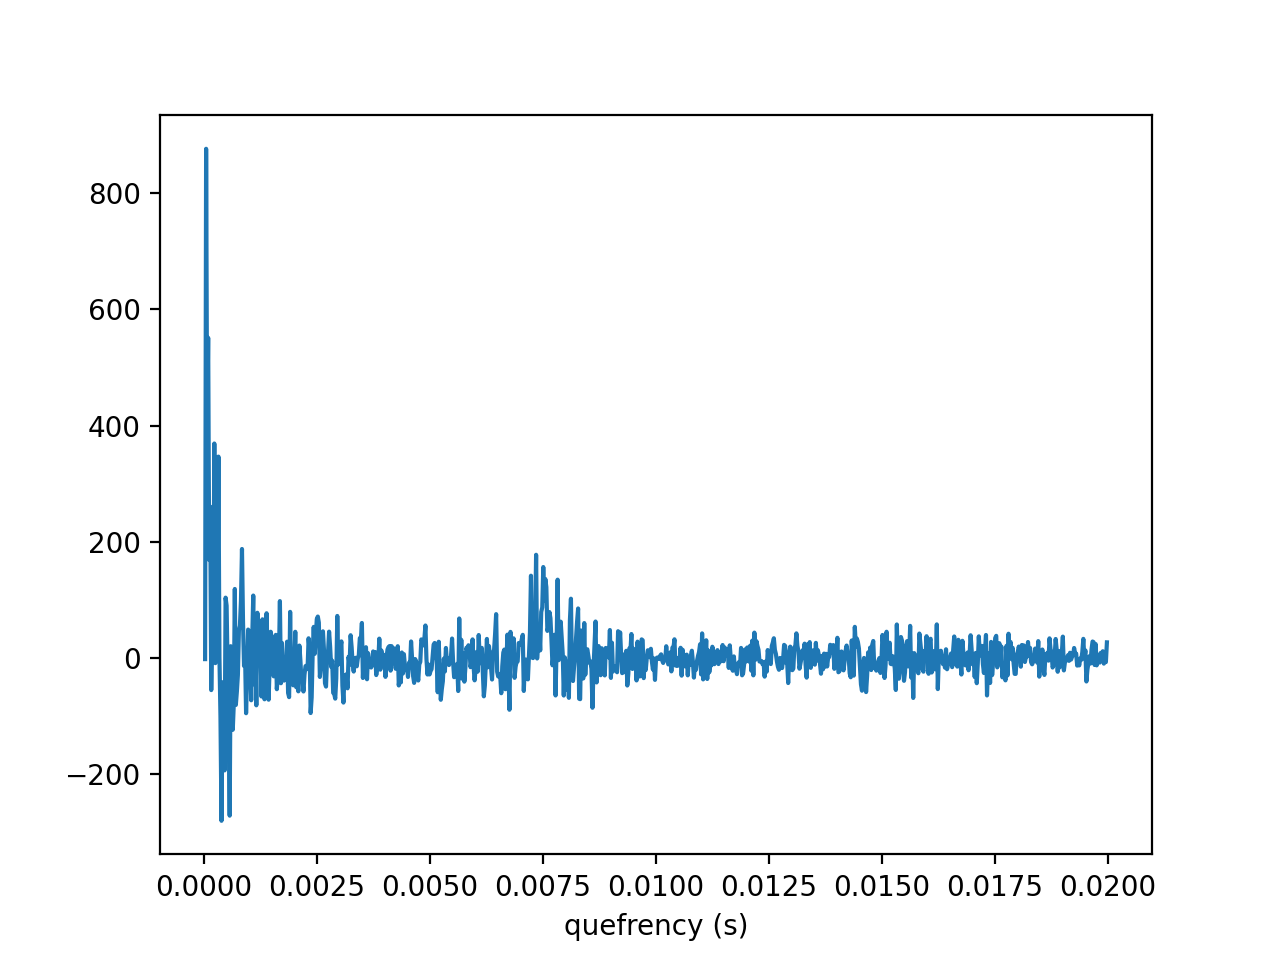

Text(0.5, 0, 'quefrency (s)')

In [79]:
windows = Hamming(windowing(filtered_sig, sample_rate, width, overlap))
C = cepstrum(windows)
E = root_mean_square(windows)
E_idx = np.int32(np.argmax(E)) 
nc = C.shape[1] #nb de colone de C 
quefrency = np.arange(nc) / sample_rate 
q_idx = np.arange(1, np.ceil(nc / 2), dtype=int) #indice des valeurs de quéfrence dans le cepstre 

plt.figure()
plt.plot(quefrency[q_idx], C[E_idx, q_idx])
plt.xlabel("quefrency (s)")


In [70]:
np.ceil?

**2. Dans le code ci-dessus, pourquoi choisit-on la ligne *E_idx* et les
colonnes *q_idx* du tableau *C* pour l'affichage ?**

* E_idx : La ligne E_idx représente l'indice de la fenêtre avec l'énergie maximale donc c'est pour utiliser la partie la plus "claire" du signal

* q_idx : représente les indices des valeurs de quéfrence dans le cepstre mais l'indice comme à >0 et prend la totalité des points, cela permet d'avoir l'axe temporelle > 0?


Au final ces choix permettent de se focaliser sur les caractéristiques les plus importantes du signal.

## V. Composantes du cepstre
Après avoir suivi toutes les étapes correctement, vous devez observer un cepstre avec deux composantes remarquables :
- 1) le filtre du conduit vocal représenté dans les valeurs basses de quéfrence
- 2) la source glottique dans les valeurs hautes de quéfrence.

**1. Déterminez la valeur de $F_0$ à partir du graphique.**

F0 = 0,0075 s (deuxième pic après le pic max à 0) 1/0,0075=133 Hz , on peut dire que c'est le F0 d'un homme ou une personne avec un voix particulièrement grave.

**2. Pour visualiser la réponse du conduit vocal, choisissez une valeur de *max_quefrency* assez petite et exécutez ce code :**

In [72]:
def plot_smooth_cepstrum(cepstrum, sample_rate, max_quefrency):
    N = len(cepstrum)
    quefrency = np.arange(N) / sample_rate
    frequency = np.arange(N) * sample_rate / N
    idx = (quefrency < max_quefrency) + (quefrency > (N/sample_rate - max_quefrency))
    mask = np.zeros(N)
    mask[idx] = 1
    plt.plot(frequency, np.real(np.fft.ifft(cepstrum)))
    plt.plot(frequency, np.real(np.fft.ifft(mask * cepstrum)), linewidth=3)

    plt.xlim ([0, np.min([(sample_rate / 2), 4000])])
    plt.xlabel ("frequency (Hz)")
    plt.ylabel ("amplitude (dB)")

<IPython.core.display.Javascript object>


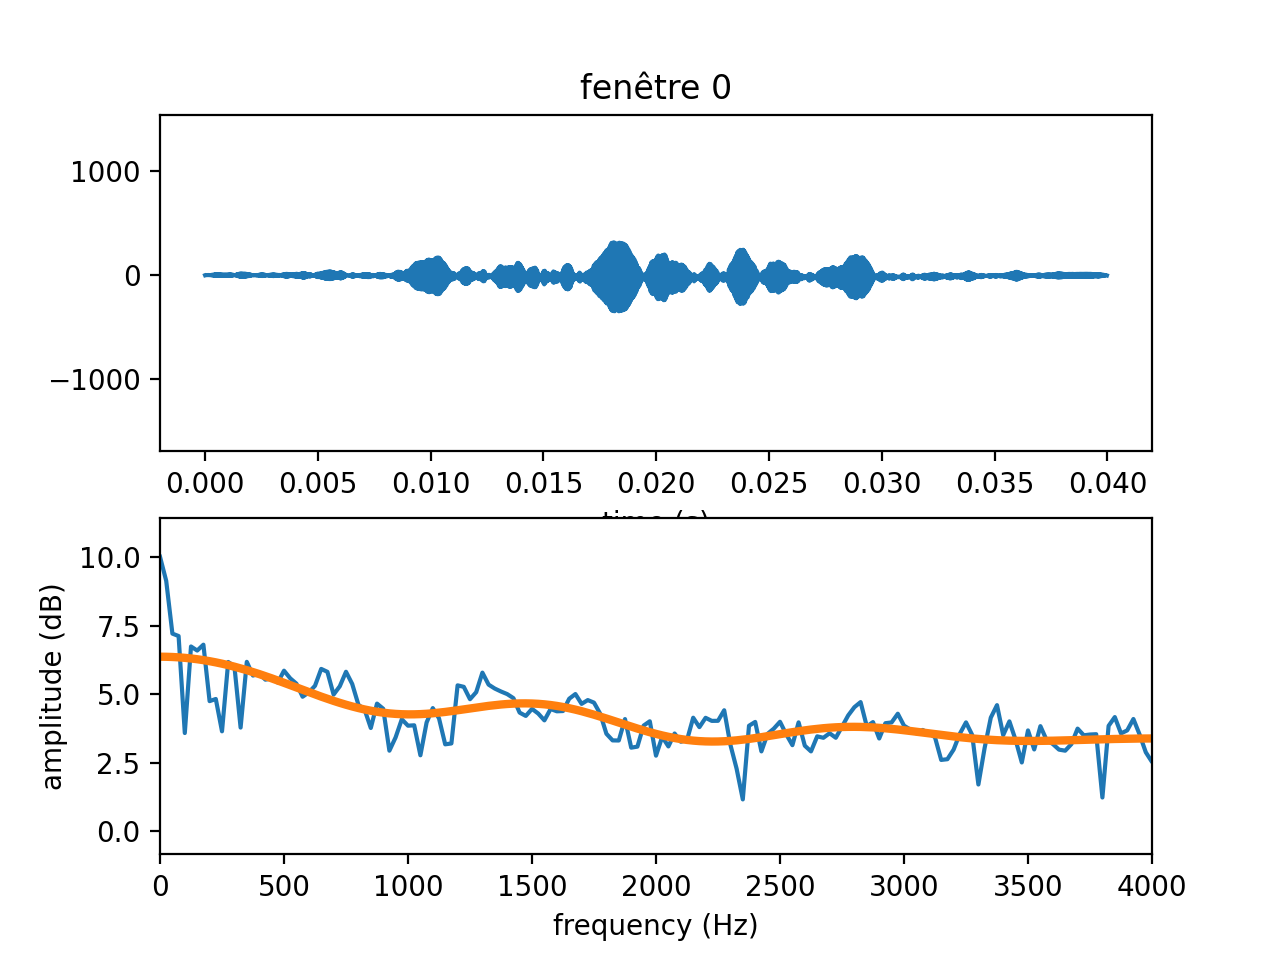

<IPython.core.display.Javascript object>


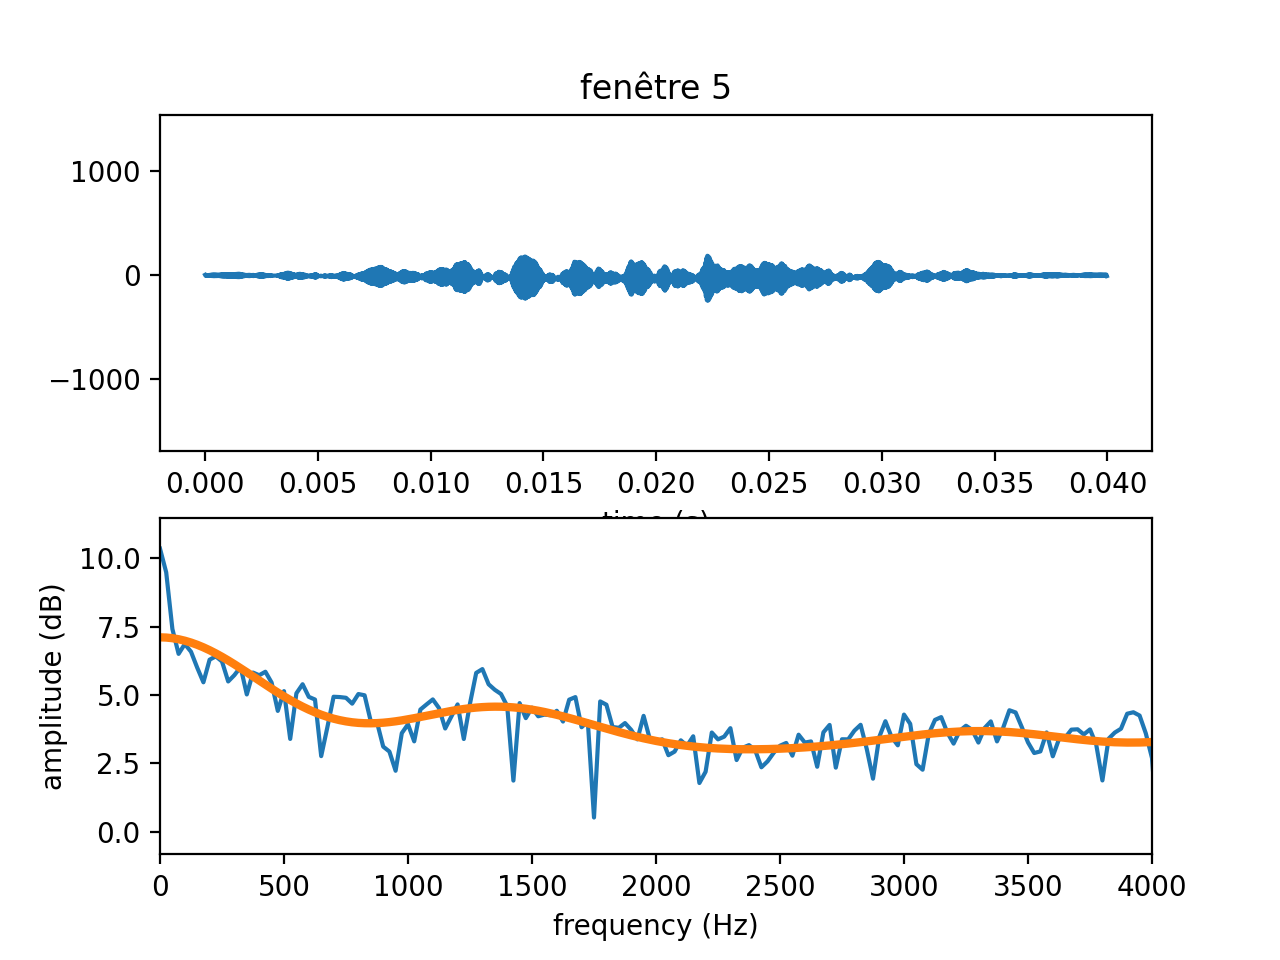

<IPython.core.display.Javascript object>


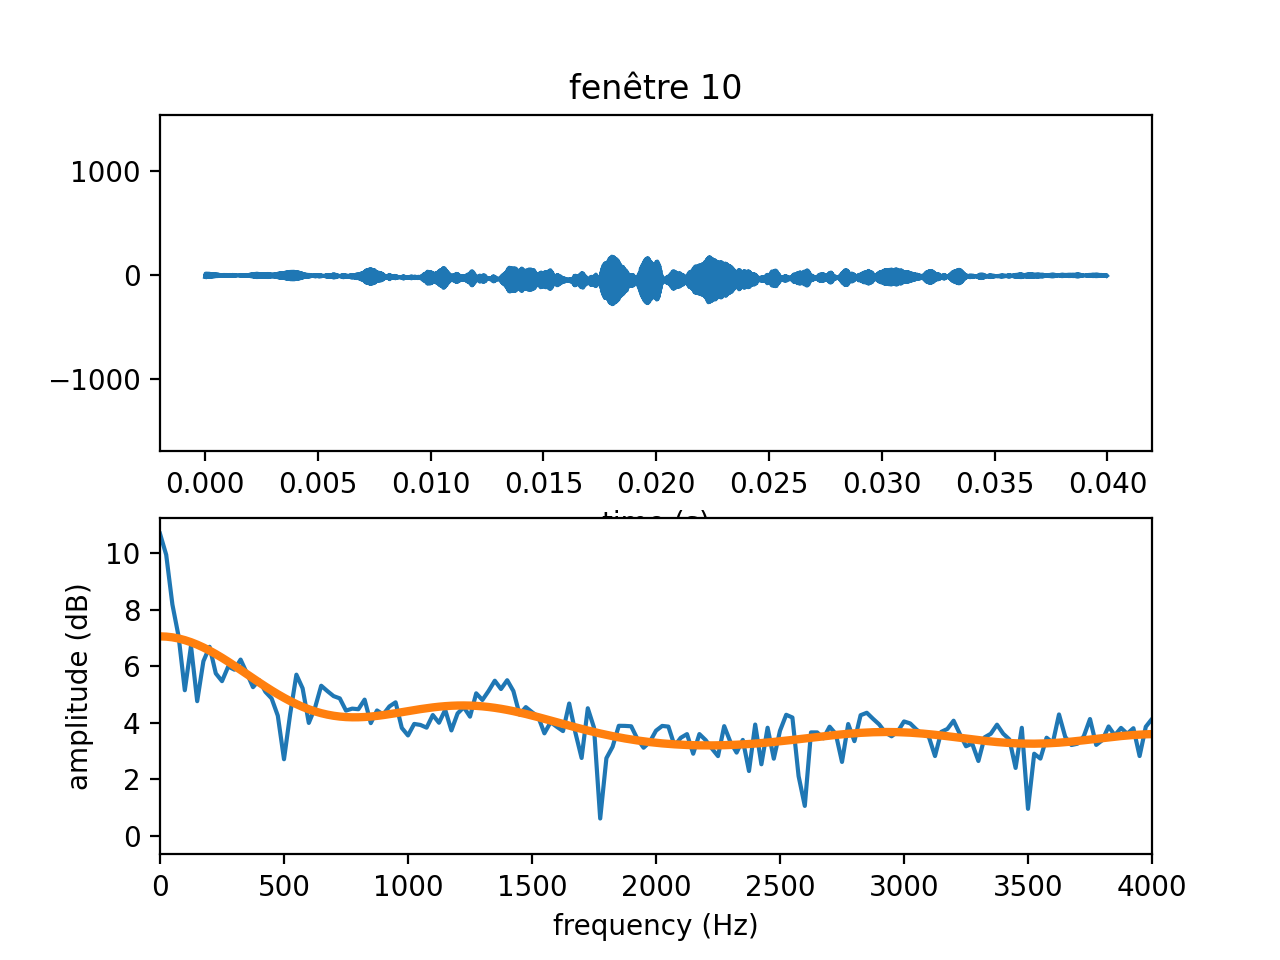

<IPython.core.display.Javascript object>


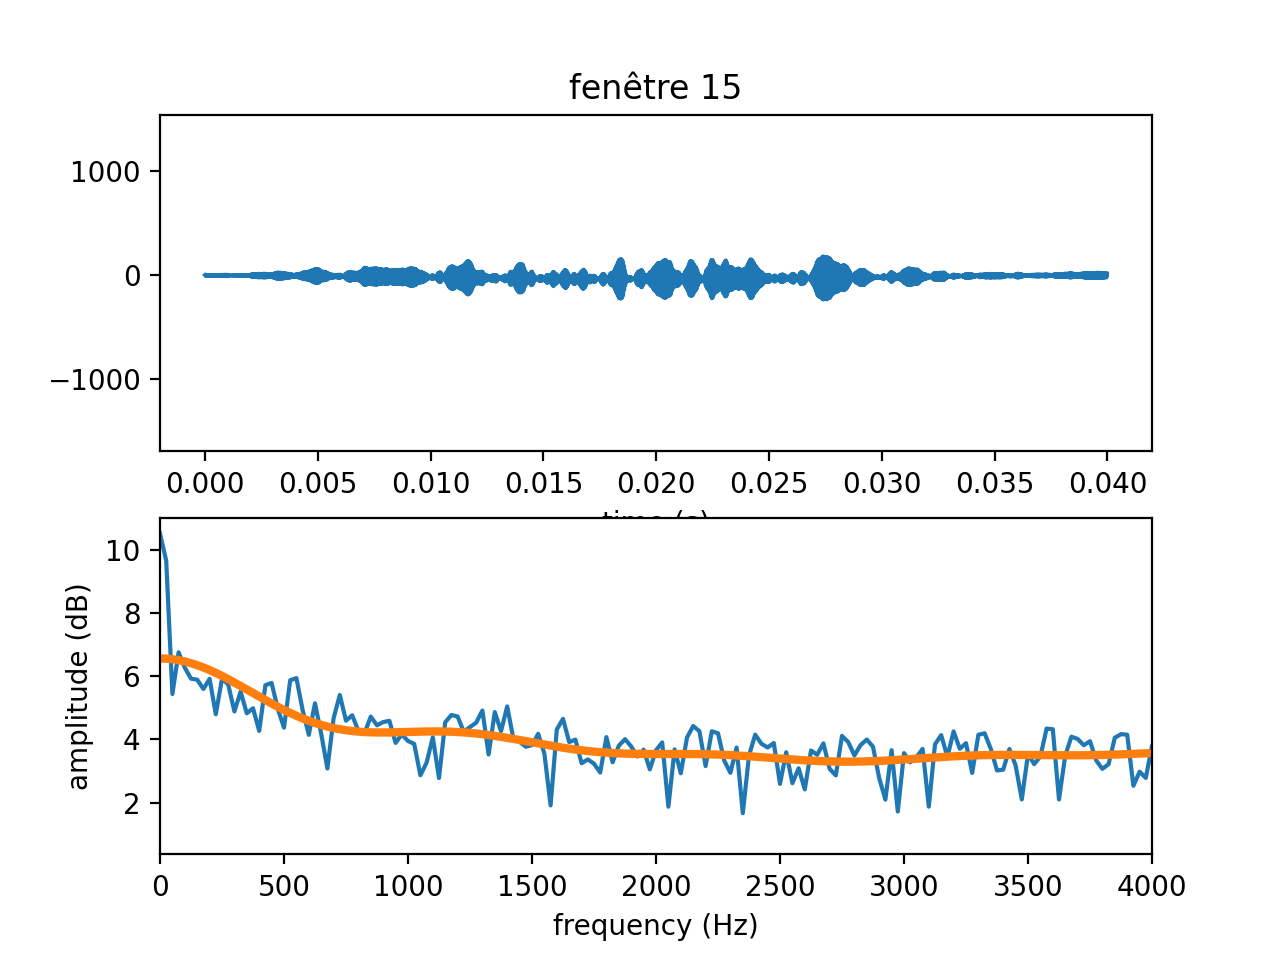

<IPython.core.display.Javascript object>


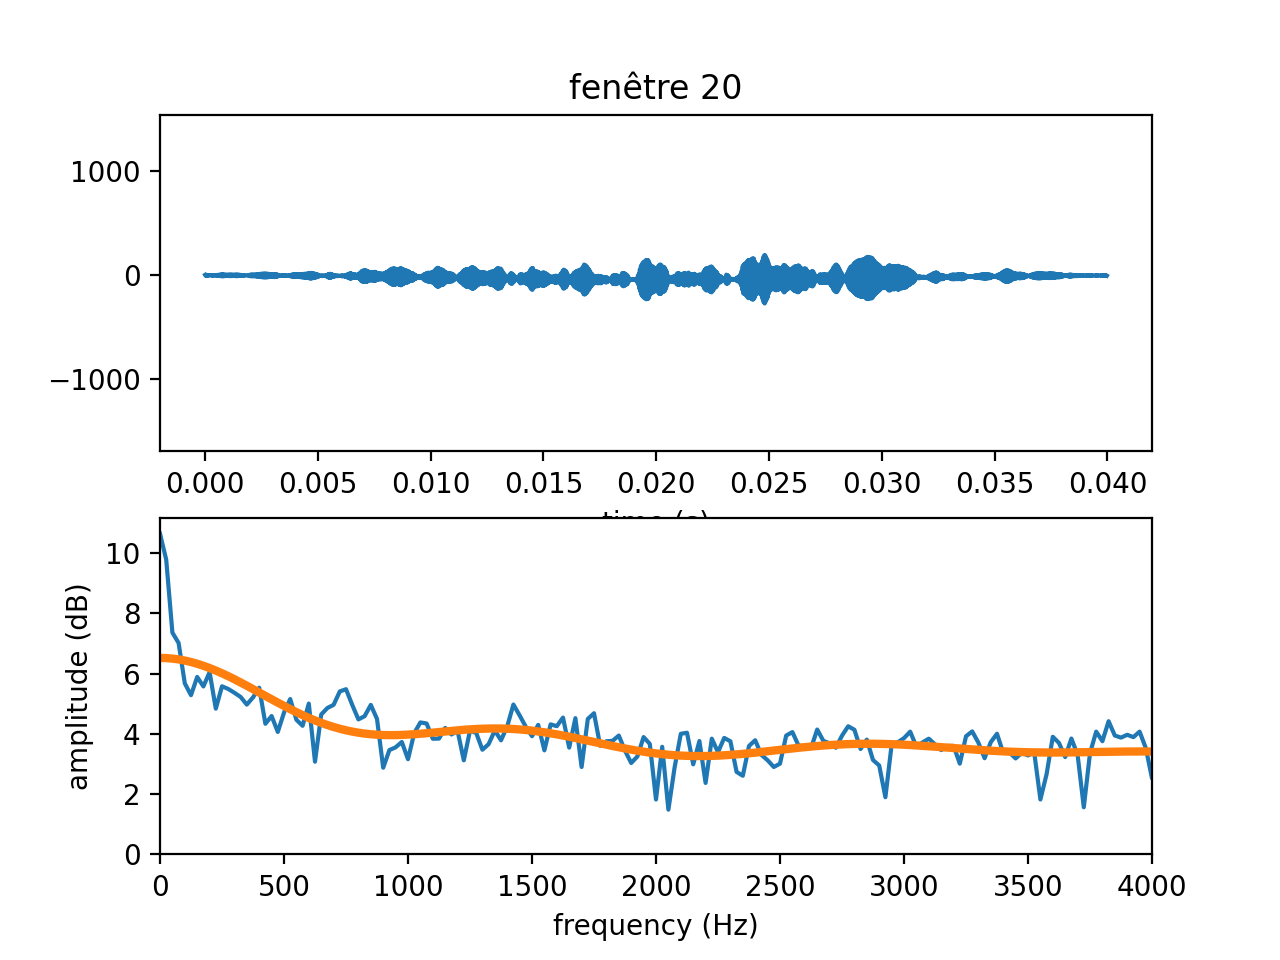

<IPython.core.display.Javascript object>


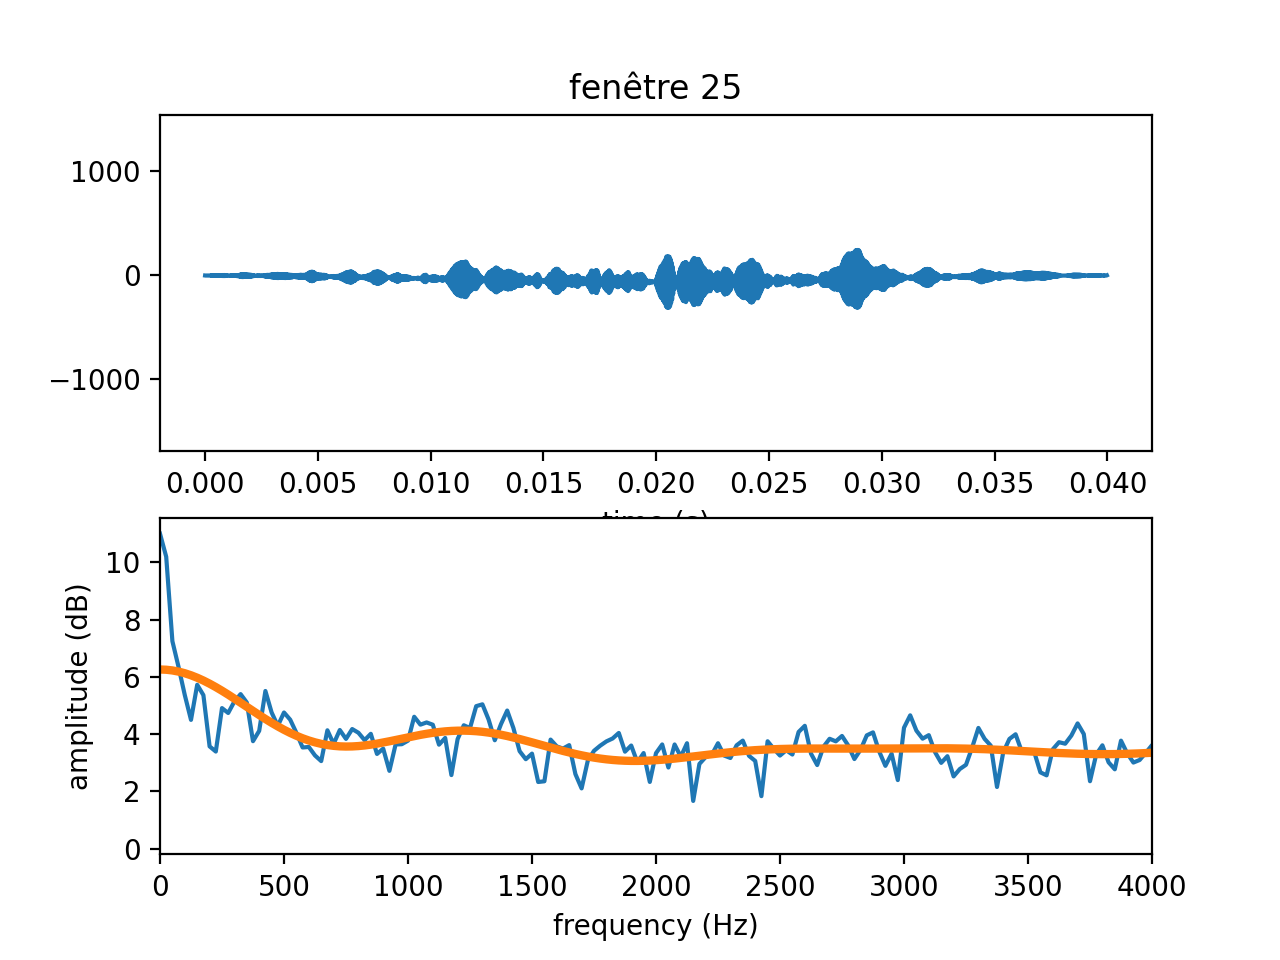

<IPython.core.display.Javascript object>


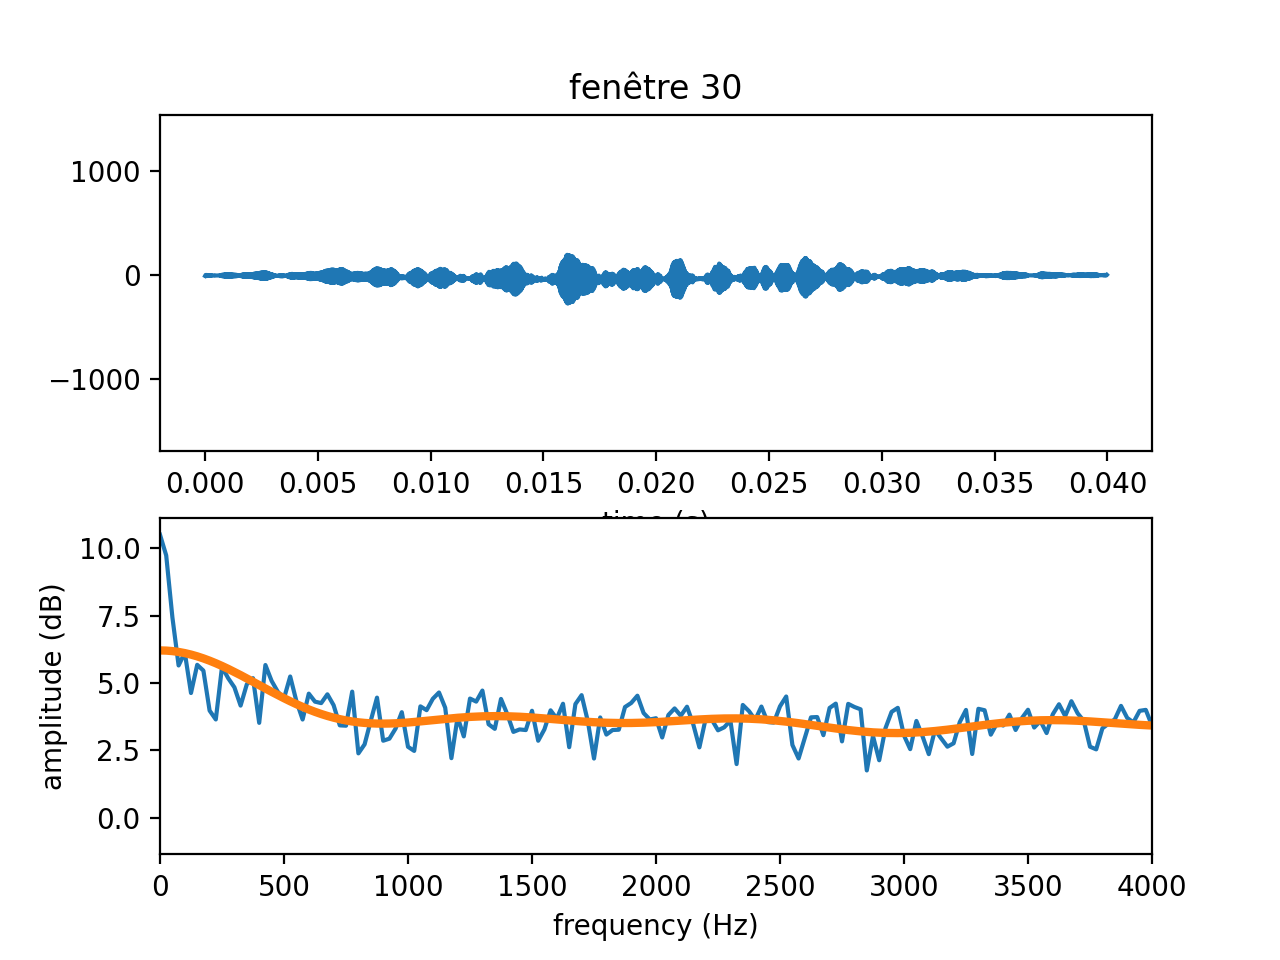

<IPython.core.display.Javascript object>


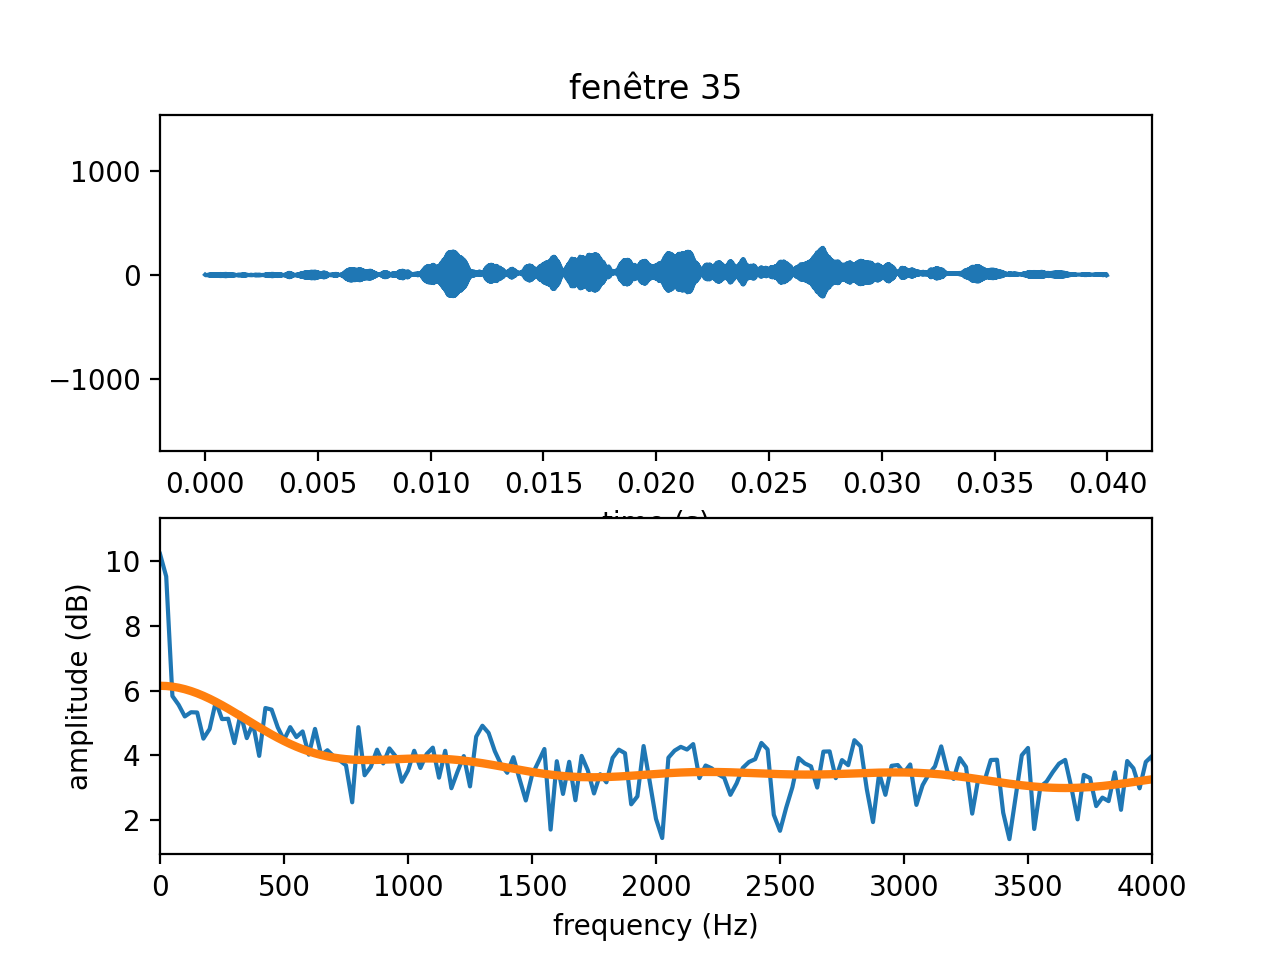

<IPython.core.display.Javascript object>


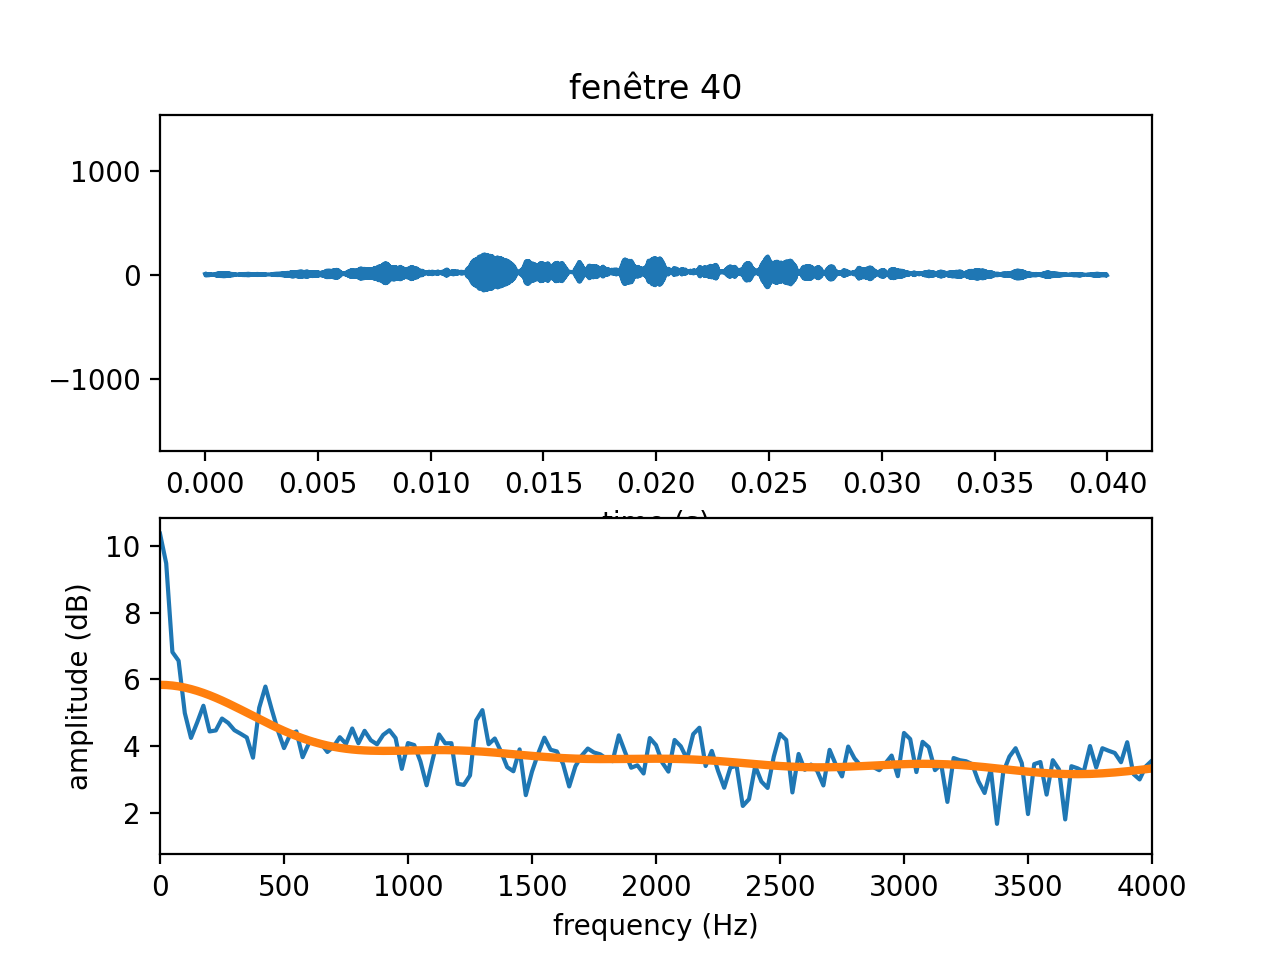

/var/folders/58/_3ghdz0d1gq8w3ffk_1tyqtr0000gn/T/ipykernel_11449/3600199575.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


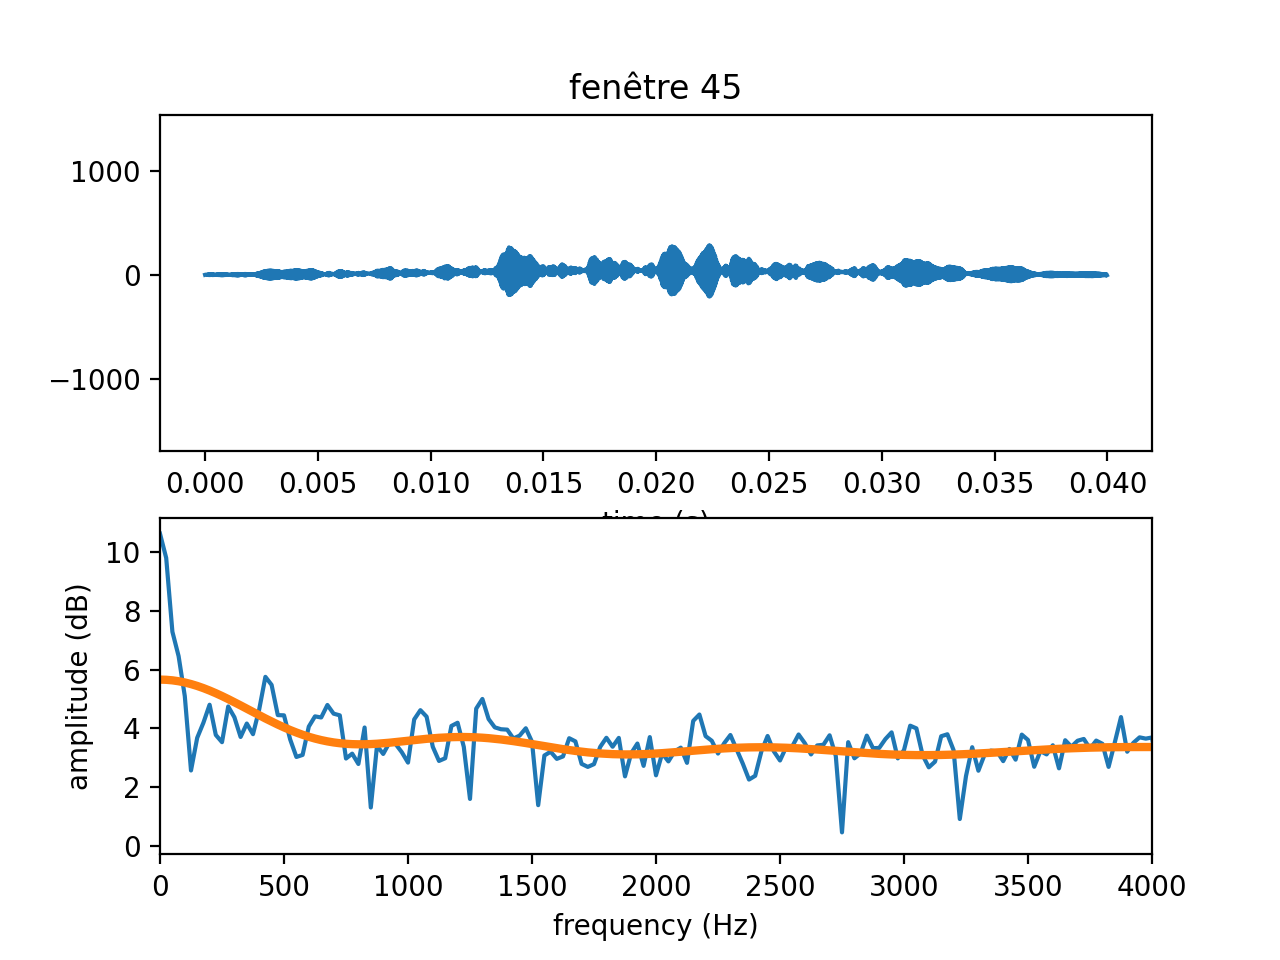

<IPython.core.display.Javascript object>


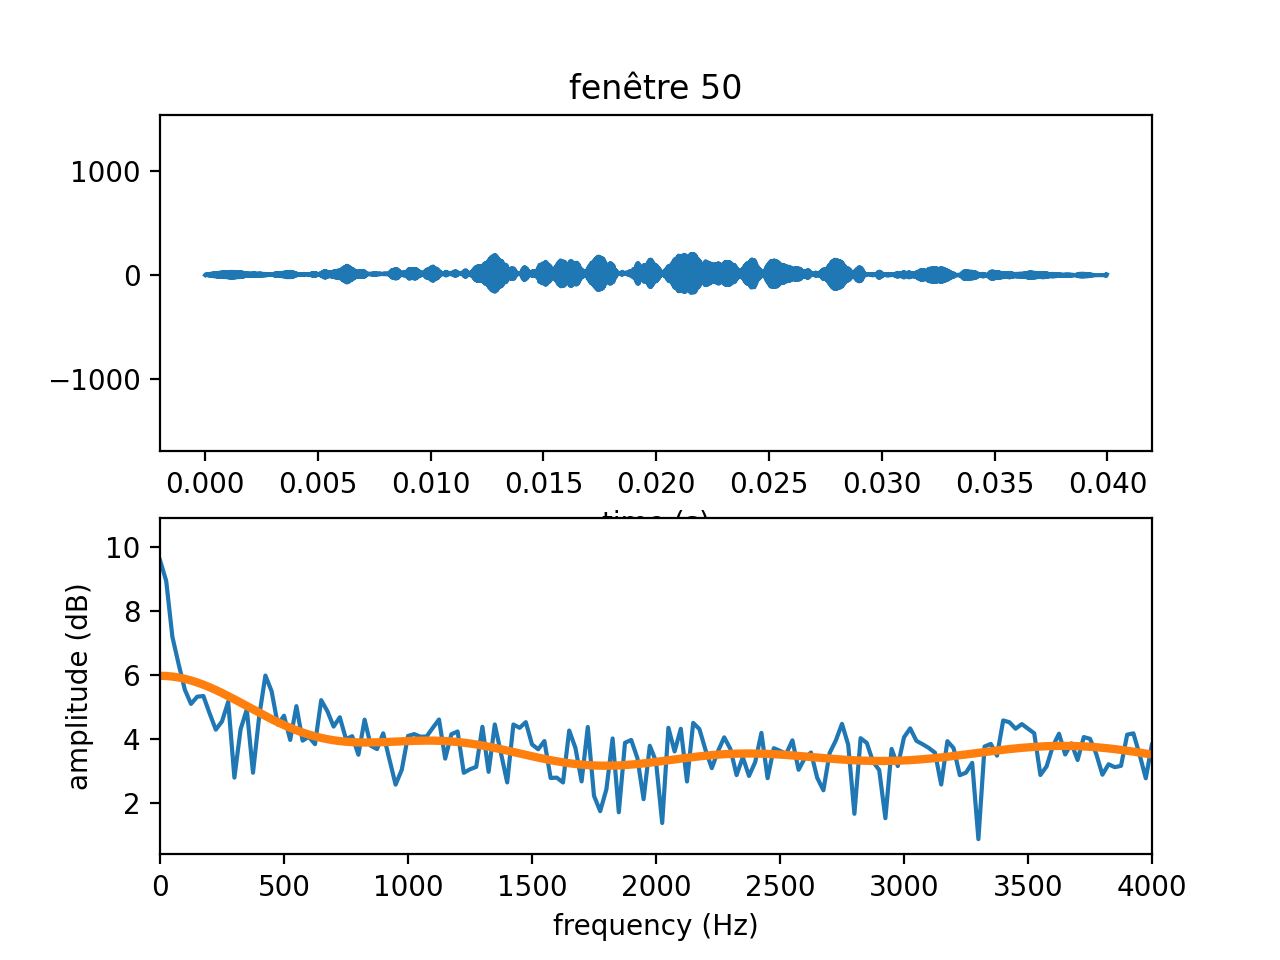

<IPython.core.display.Javascript object>


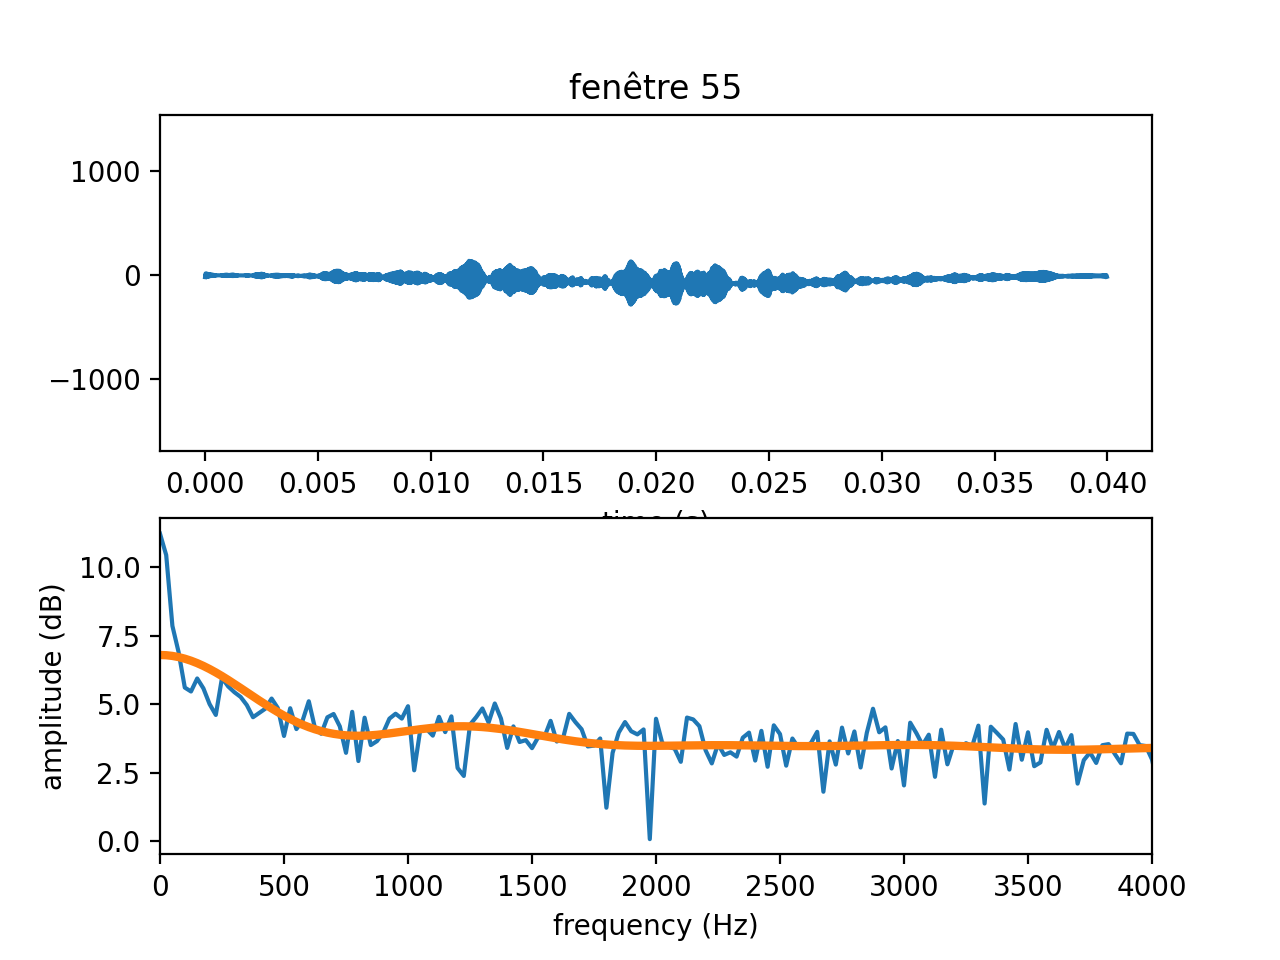

<IPython.core.display.Javascript object>


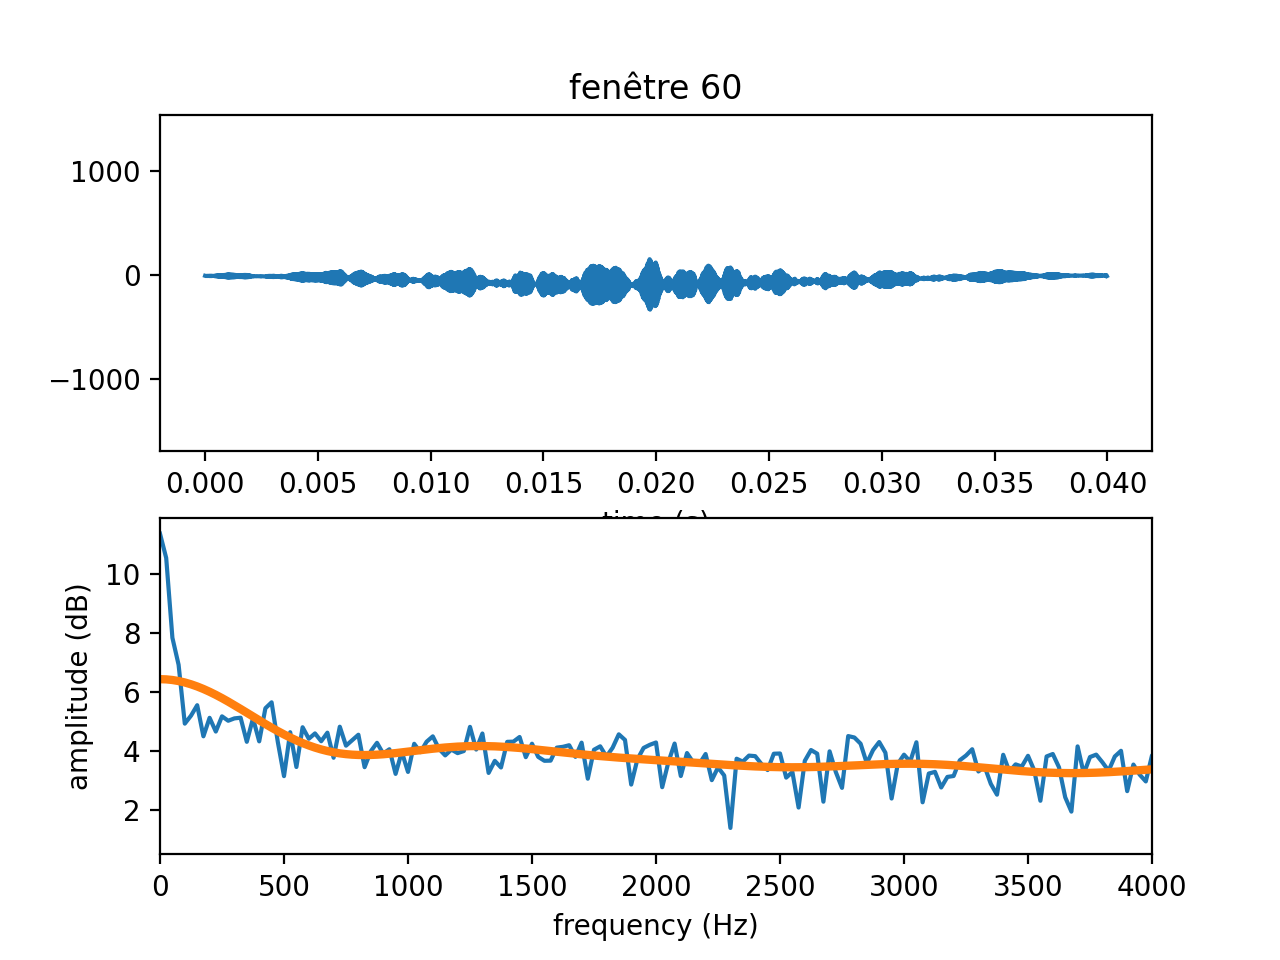

<IPython.core.display.Javascript object>


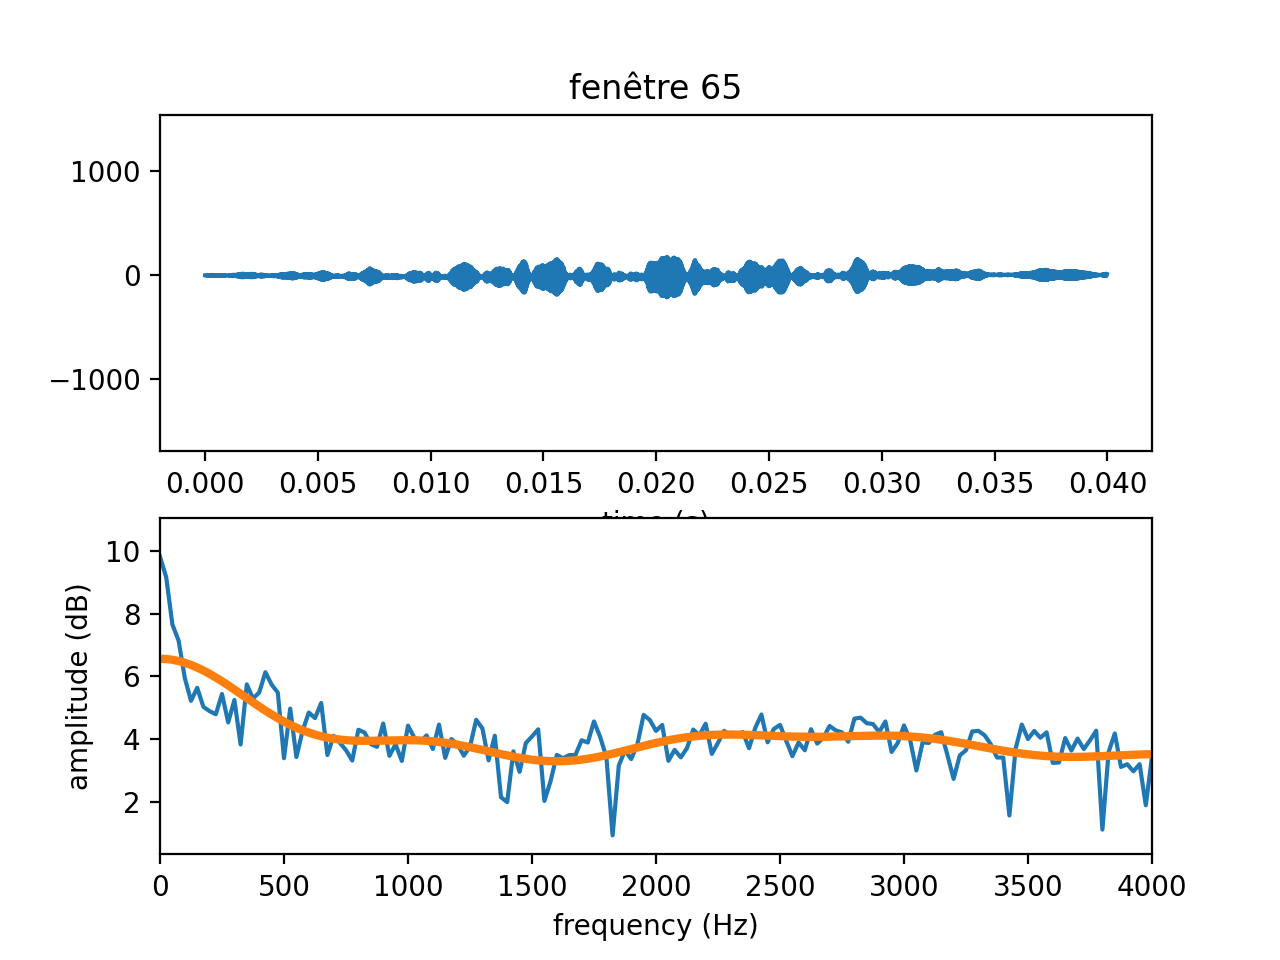

<IPython.core.display.Javascript object>


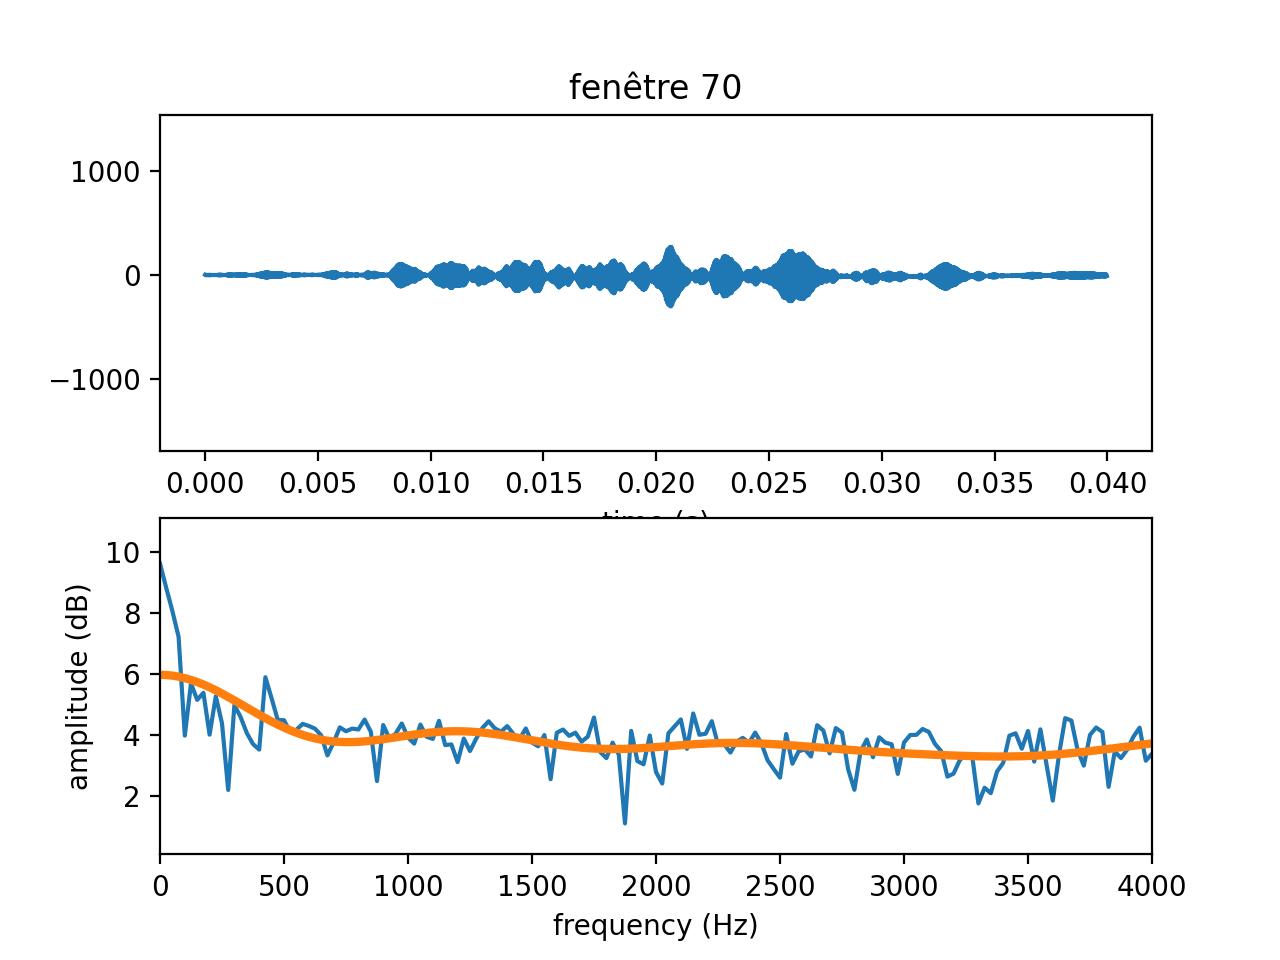

<IPython.core.display.Javascript object>


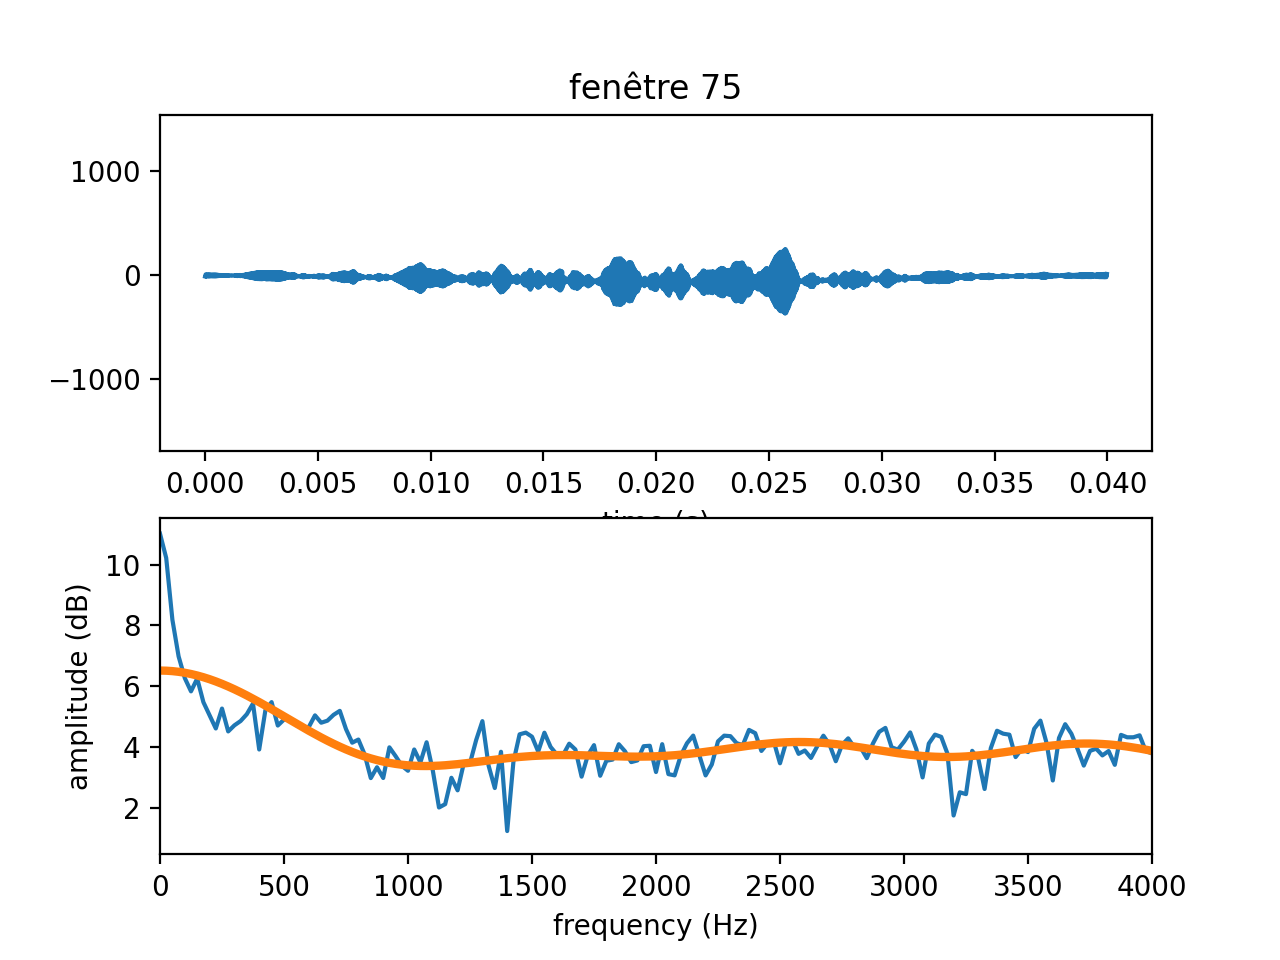

<IPython.core.display.Javascript object>


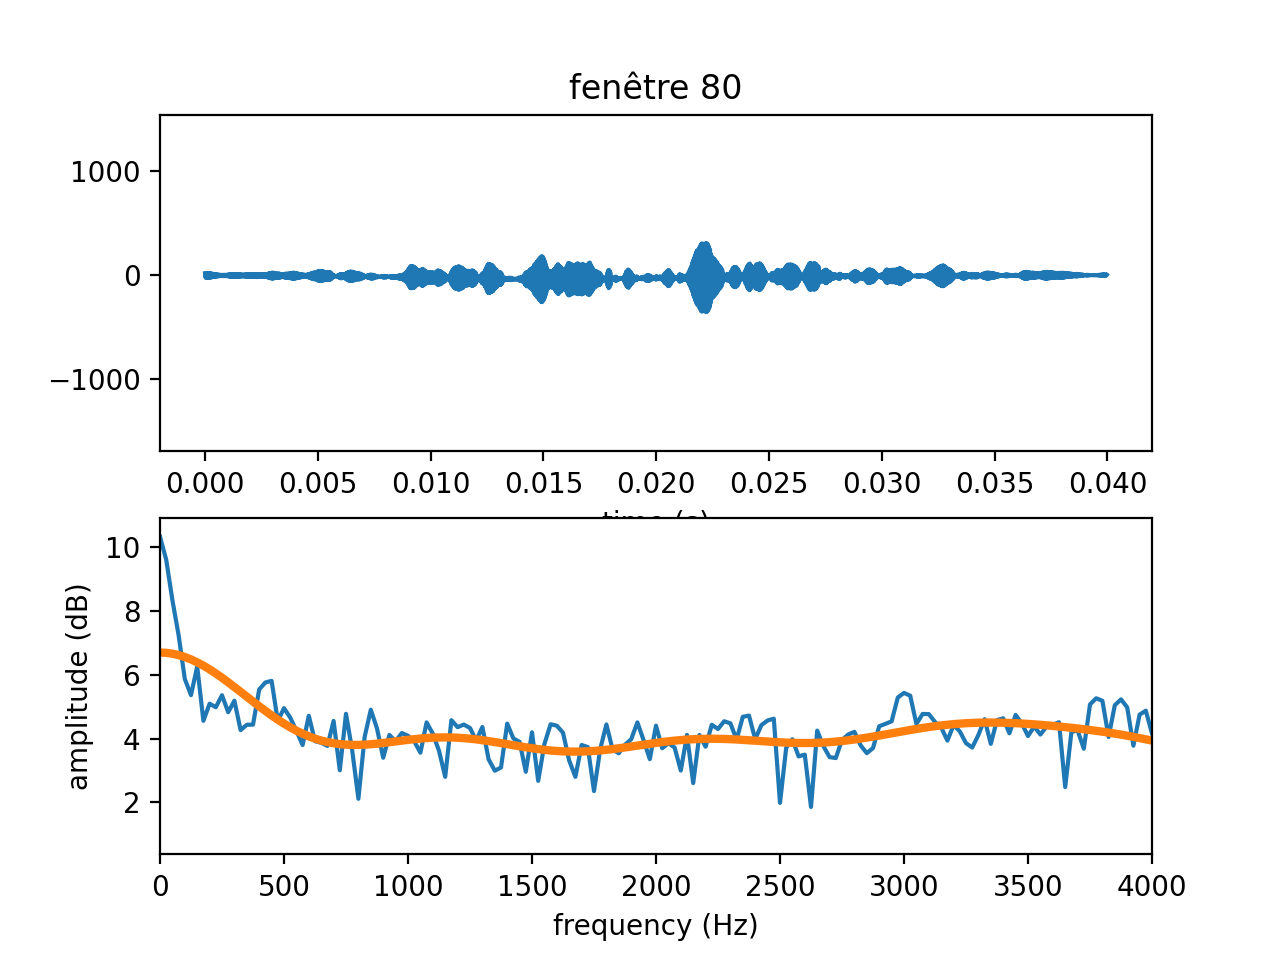

<IPython.core.display.Javascript object>


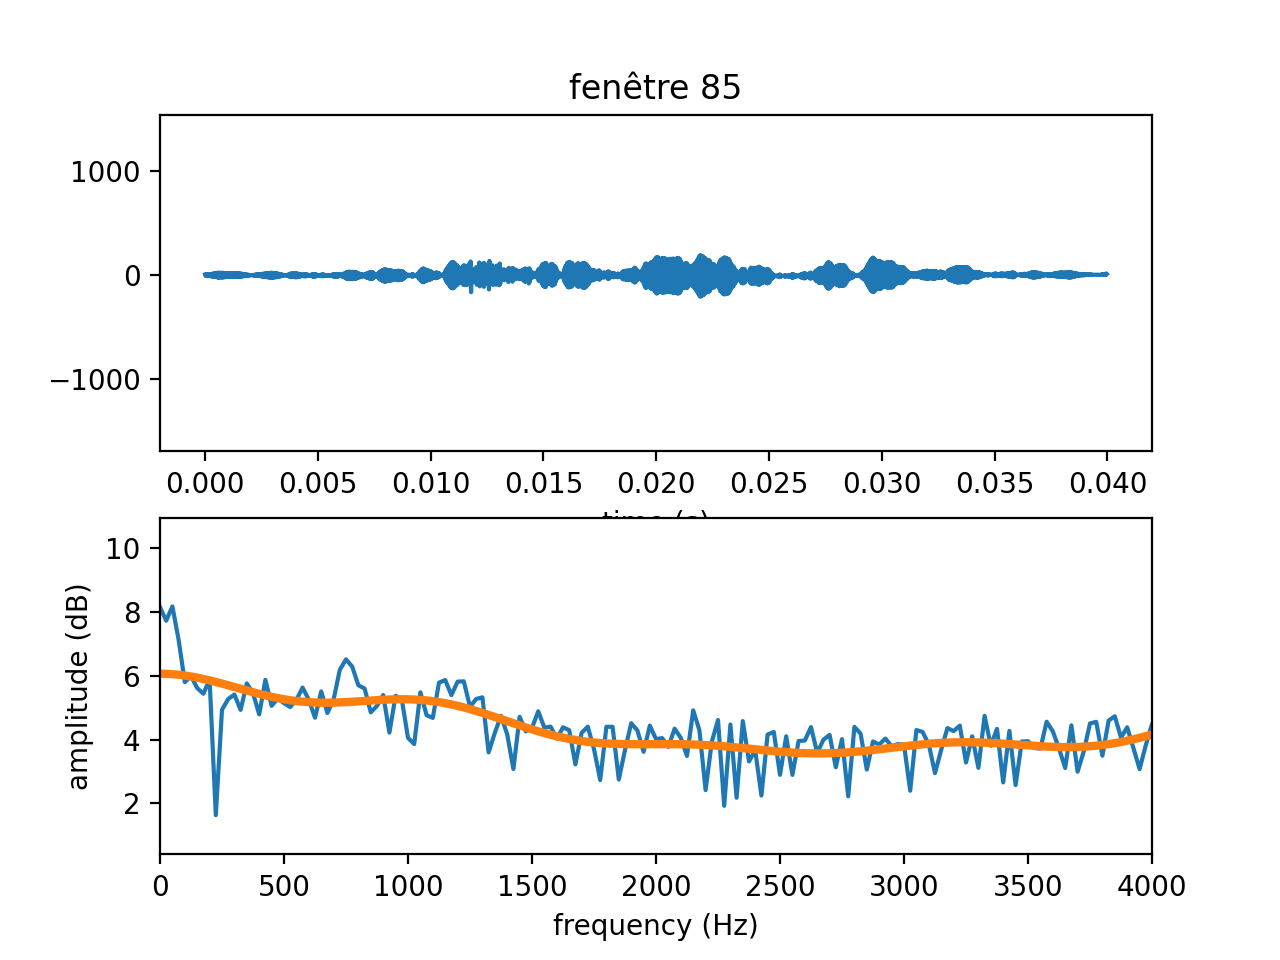

<IPython.core.display.Javascript object>


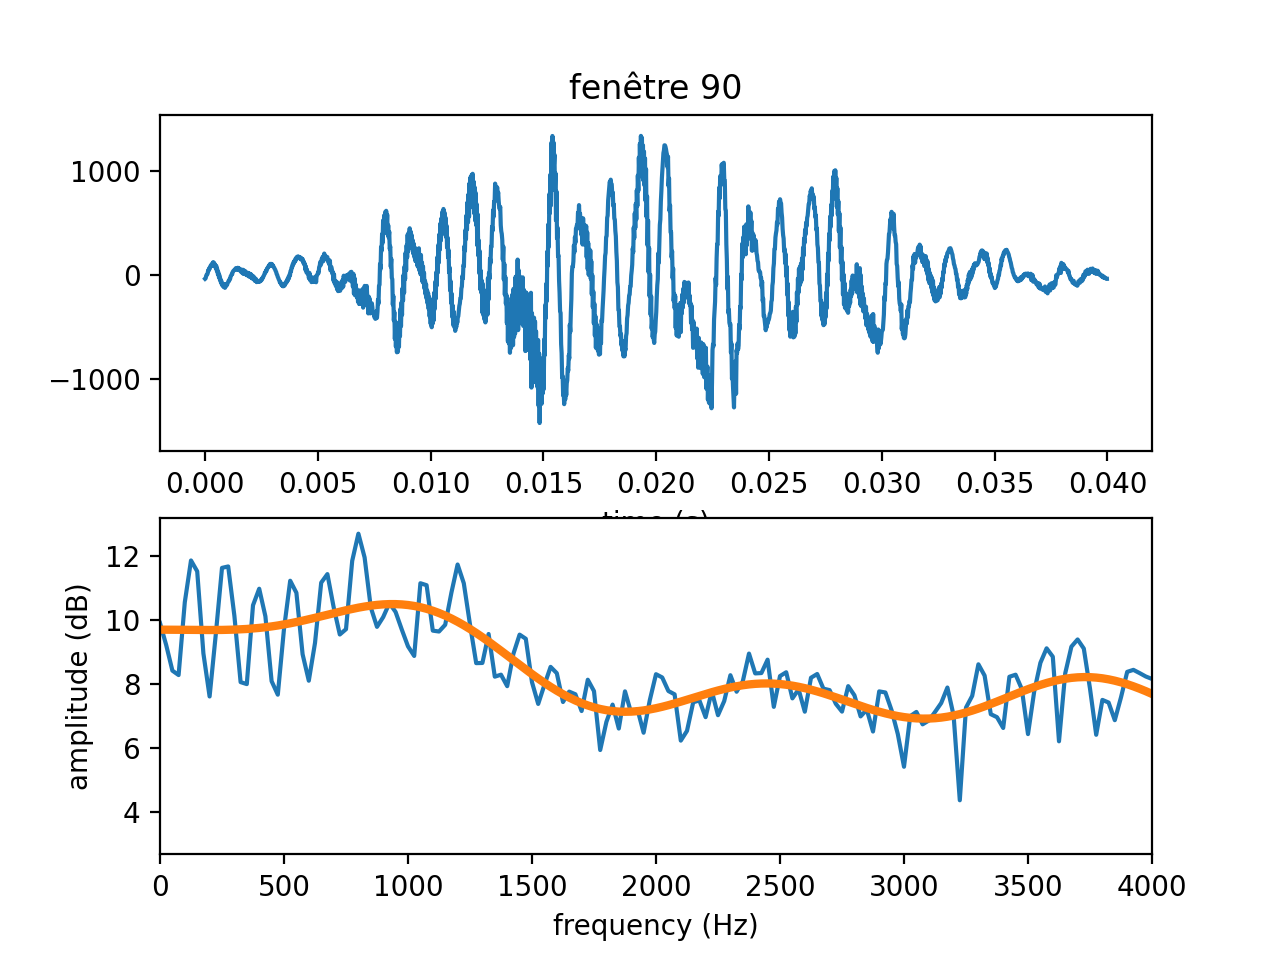

<IPython.core.display.Javascript object>


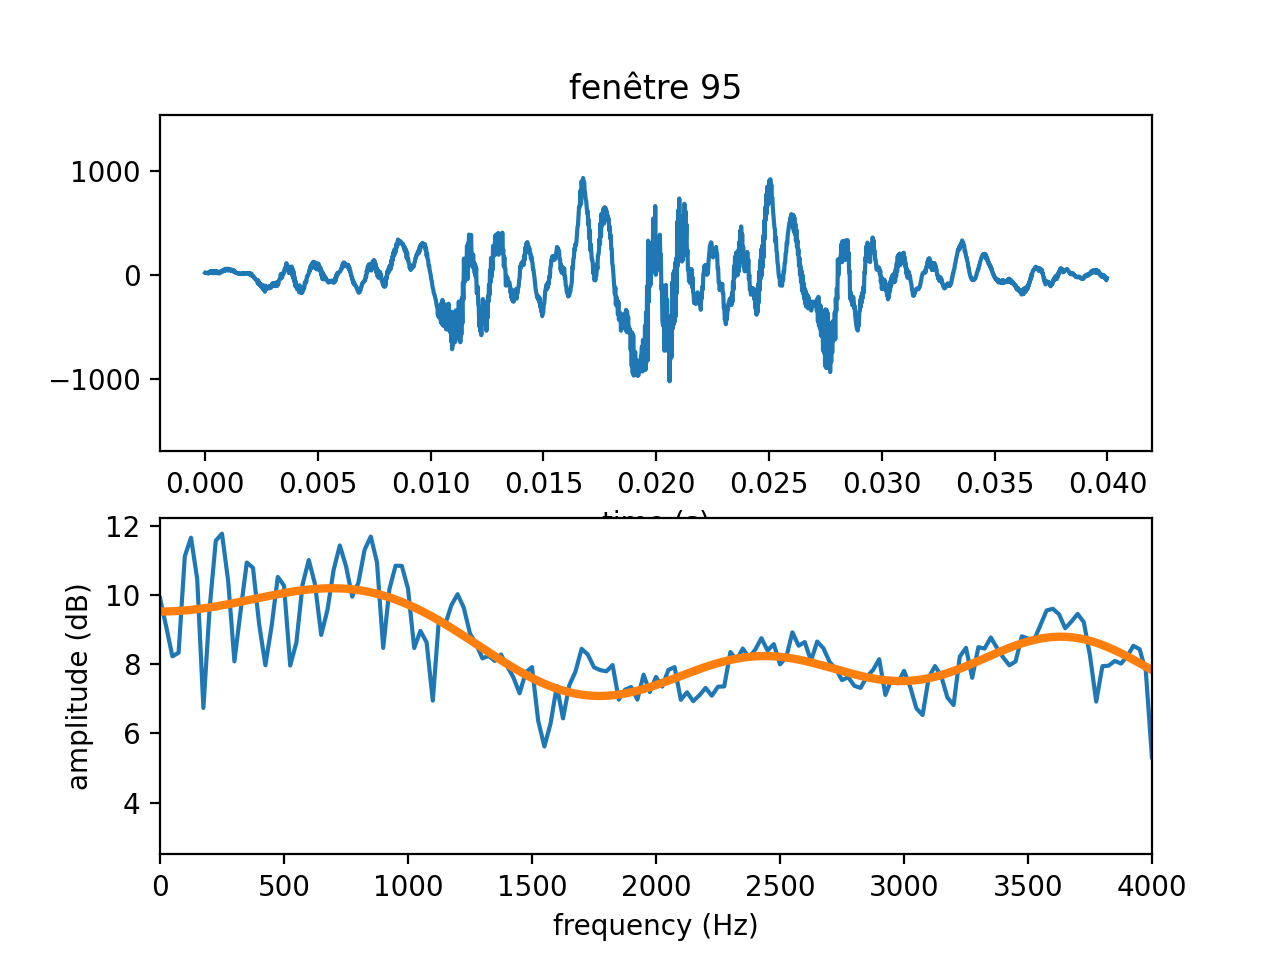

<IPython.core.display.Javascript object>


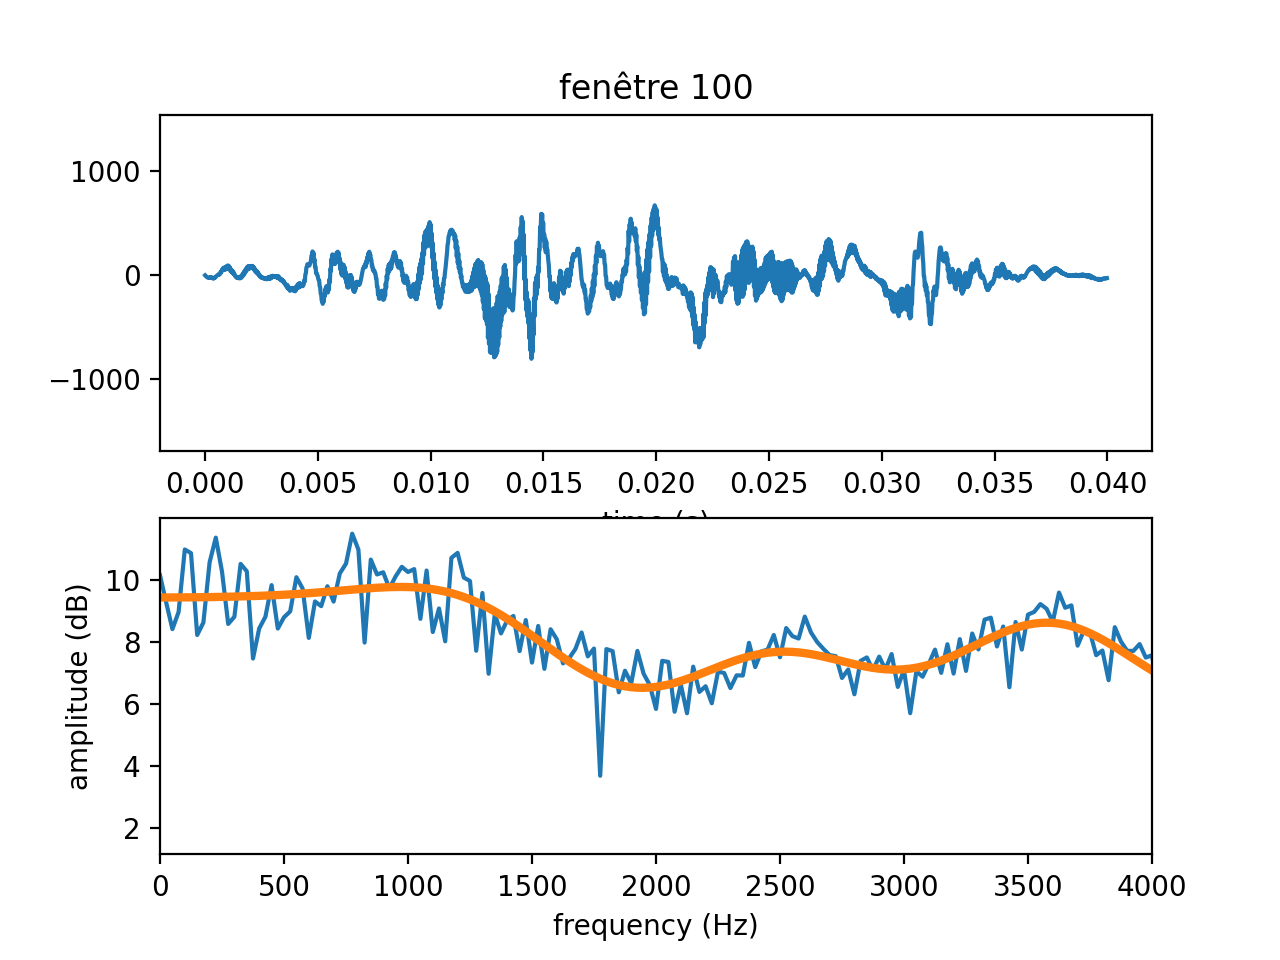

<IPython.core.display.Javascript object>


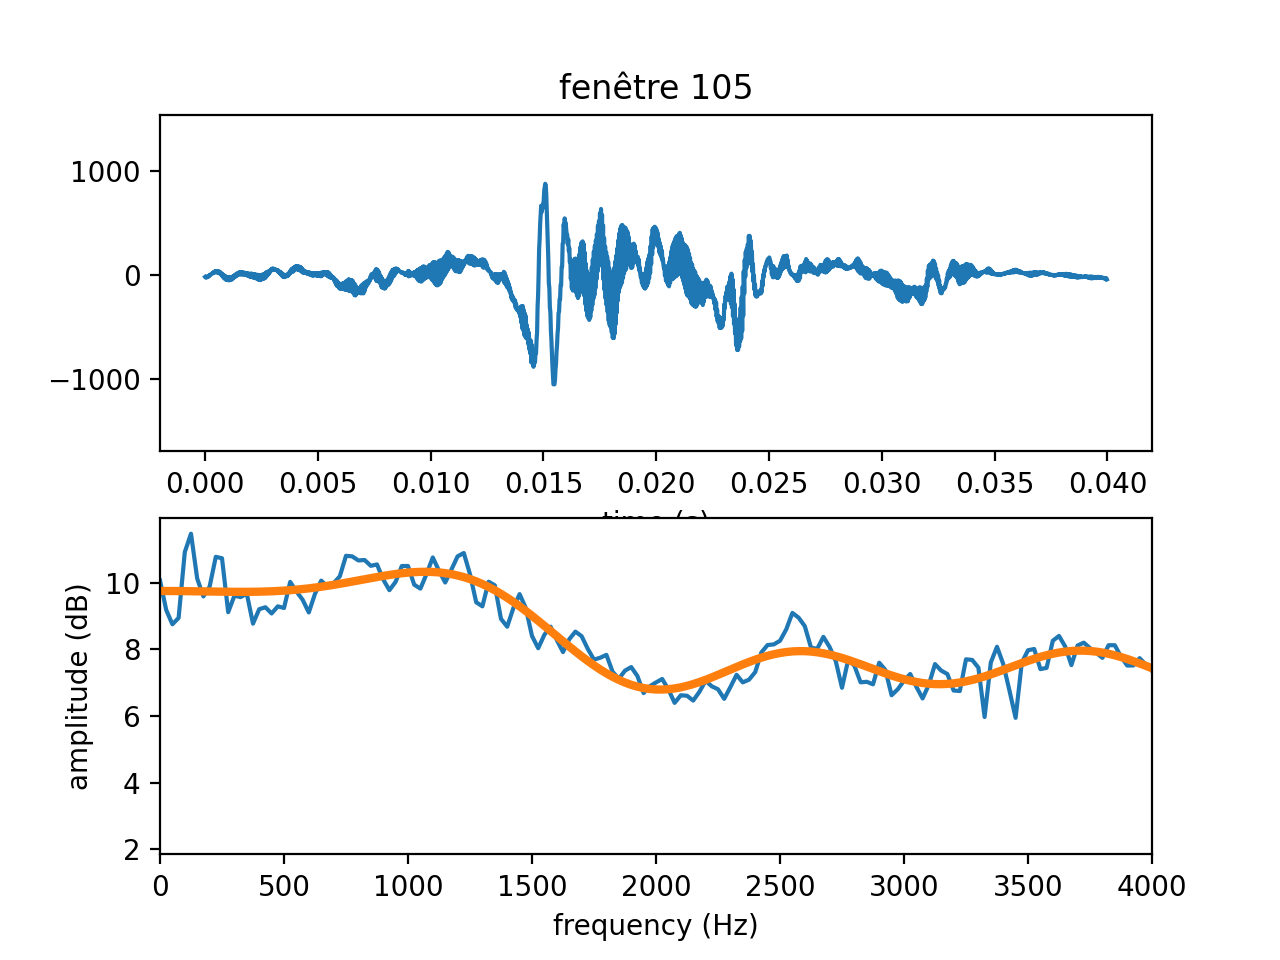

<IPython.core.display.Javascript object>


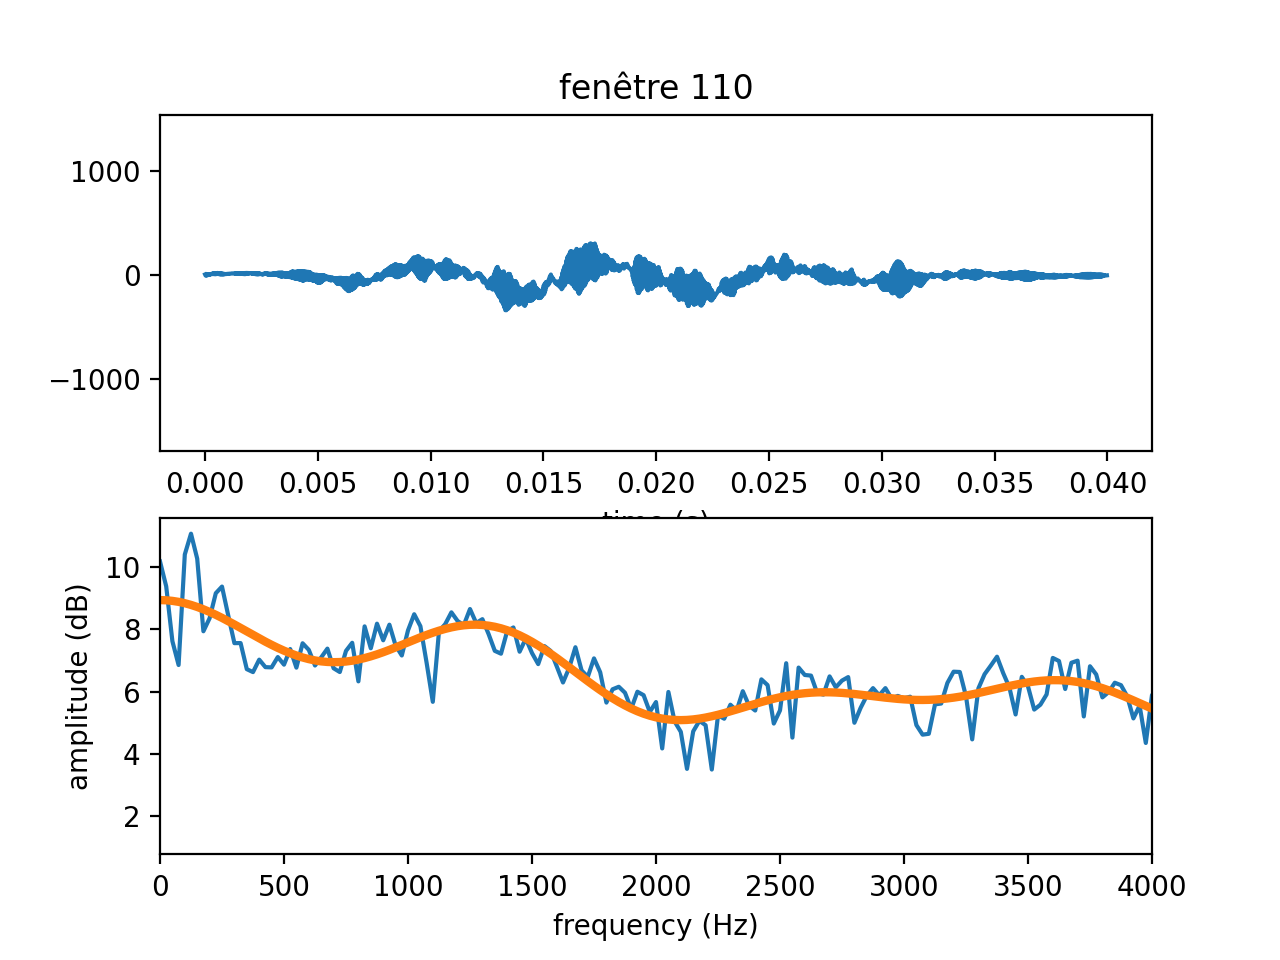

<IPython.core.display.Javascript object>


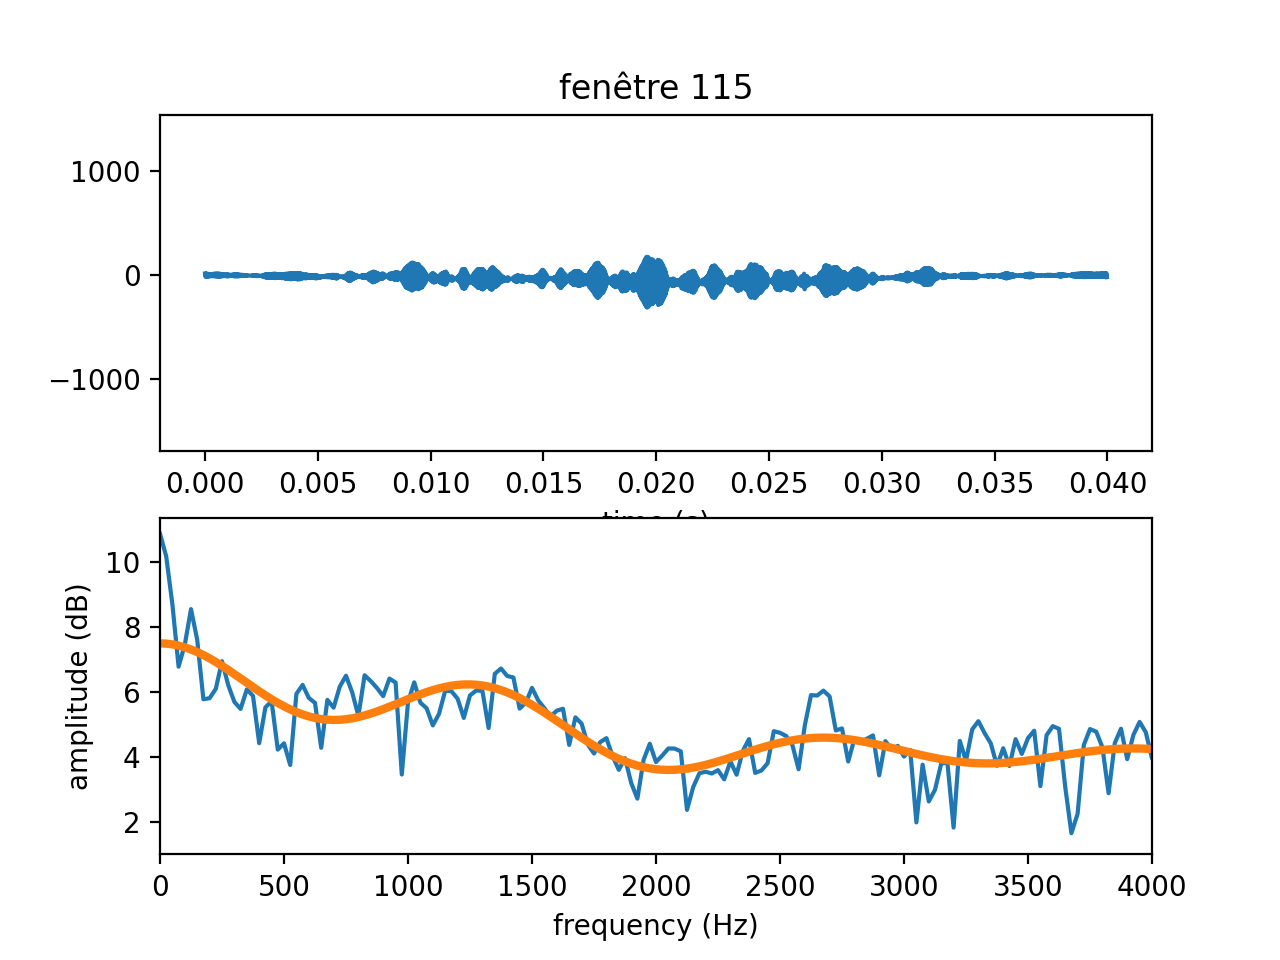

<IPython.core.display.Javascript object>


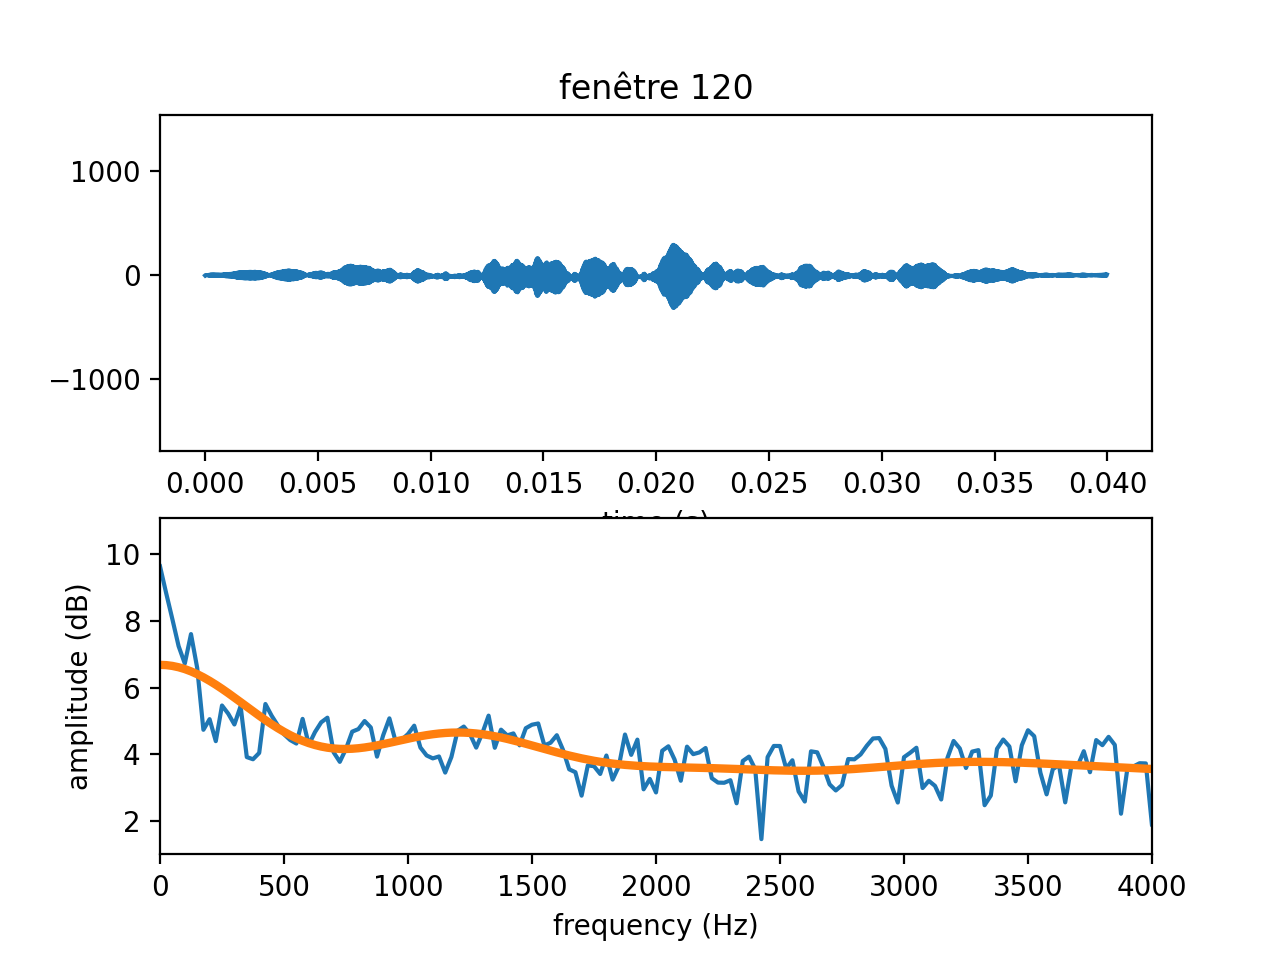

<IPython.core.display.Javascript object>


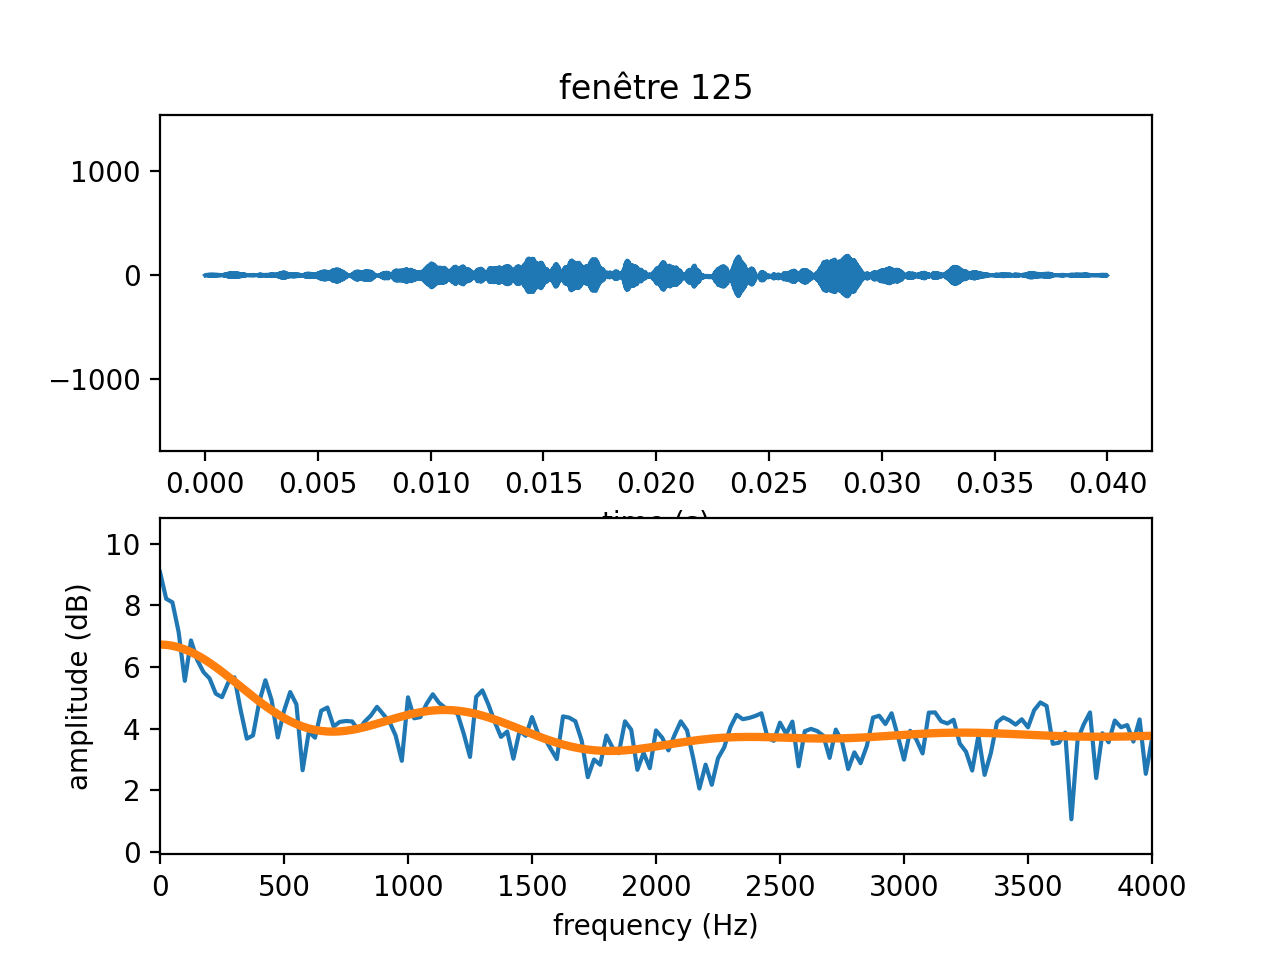

<IPython.core.display.Javascript object>


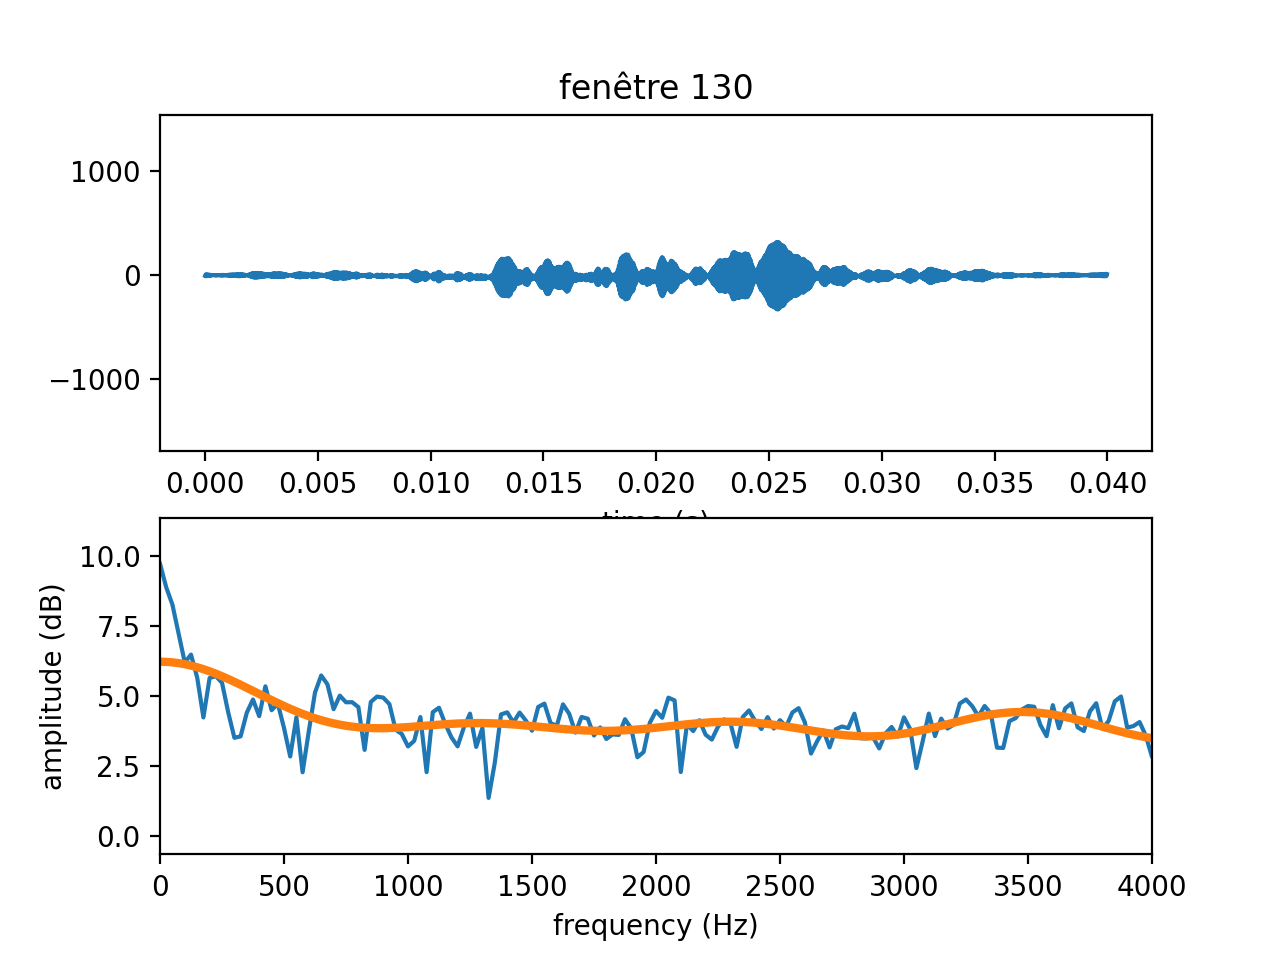

In [82]:
#max_quefrency = 0.0075
max_quefrency = 0.001
nc, nr = C.shape
t = np.arange(nr) / sample_rate
ylim = [np.min(windows), np.max(windows)]

first_win_idx = 0
step = 5
for idx in range(first_win_idx, nc, step):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, windows[idx, :])
    plt.title("fenêtre "+str(idx))
    plt.xlabel ("time (s)")
    plt.ylim(ylim)
    plt.subplot (2, 1, 2);
    plot_smooth_cepstrum(C[idx, :], sample_rate, max_quefrency)

**3. Essayez d'autres valeurs pour *max_quefrency*. Lisez le code de la fonction *plot_smooth_cepstrum* et essayez de comprendre l'effet de *max_quefrency*.**

J'ai essayé avec max_quefrency = 0.0075, plus on augmente le max de la fréquence moins la courbe est lissé car elle suit davantage l'allure du signal original, donc on perçoit moins les pics de fréquences car on garde les effets du bruit sur le signal, ce qui nous empêche de distinguer les pics de fréquences, alors que ce que l'on cherche à voir ceux sont justement les formants.

Dans le code plot_smooth_cepstrum, la valeur de quefrence agit un peu commme un seuil. Lorsqu'on prends une petit valeur alors on aurra un effet plu lisse et quand on augmente la valeur on laissera plus de haute fréquene passer.  Faut le voir comme un seuil valeur max a considérer.
Si on l'augmente on va avoir plus de HF si on le diminue on va avoir plus de BF
Donc choisir le seuil en fonction de ce qu'on veut visualiser F0, F1, F2,...
    

4. Peut-on estimer les valeurs de $F_1$ et $F_2$ à partir des graphiques obtenus ?

Oui, la premiere "bosses" ou "pic" correponds à F0, et le deuxième et troisième pics sont respectivement F1 et F2. Prenons l'exemple de max_quefrequency = 0.001 $F_1$ = 2500 Hz et $F_2$ = 3500 Hz (rappel deuxième et troisième bosse)


## VI. Représentation des voyelles dans l'espace des coefficients cepstraux
Le code ci-desosus contient un résumé de ce TP.
Il extrait les premiers coefficients cepstraux des cinq voyelles /a/, /e/, /i/, /o/ et /u/ autour du maximum de l'énergie de chaque voyelle.
1. Regardez et exécutez ce code.

/var/folders/58/_3ghdz0d1gq8w3ffk_1tyqtr0000gn/T/ipykernel_11449/600983769.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nb_cc = np.int(np.floor((max_quefrency / width) * windows.shape[1]))


<IPython.core.display.Javascript object>


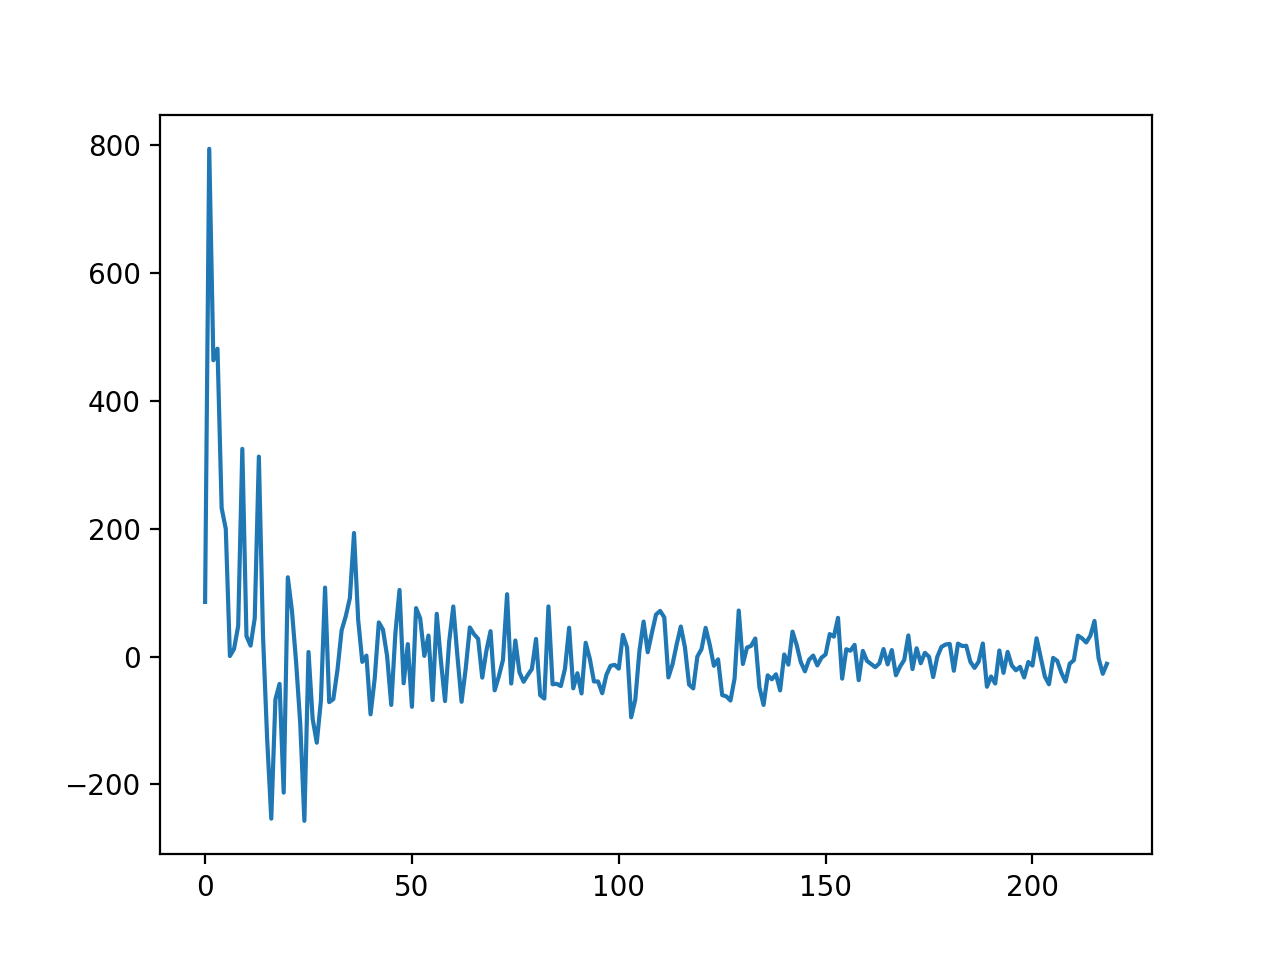

<IPython.core.display.Javascript object>


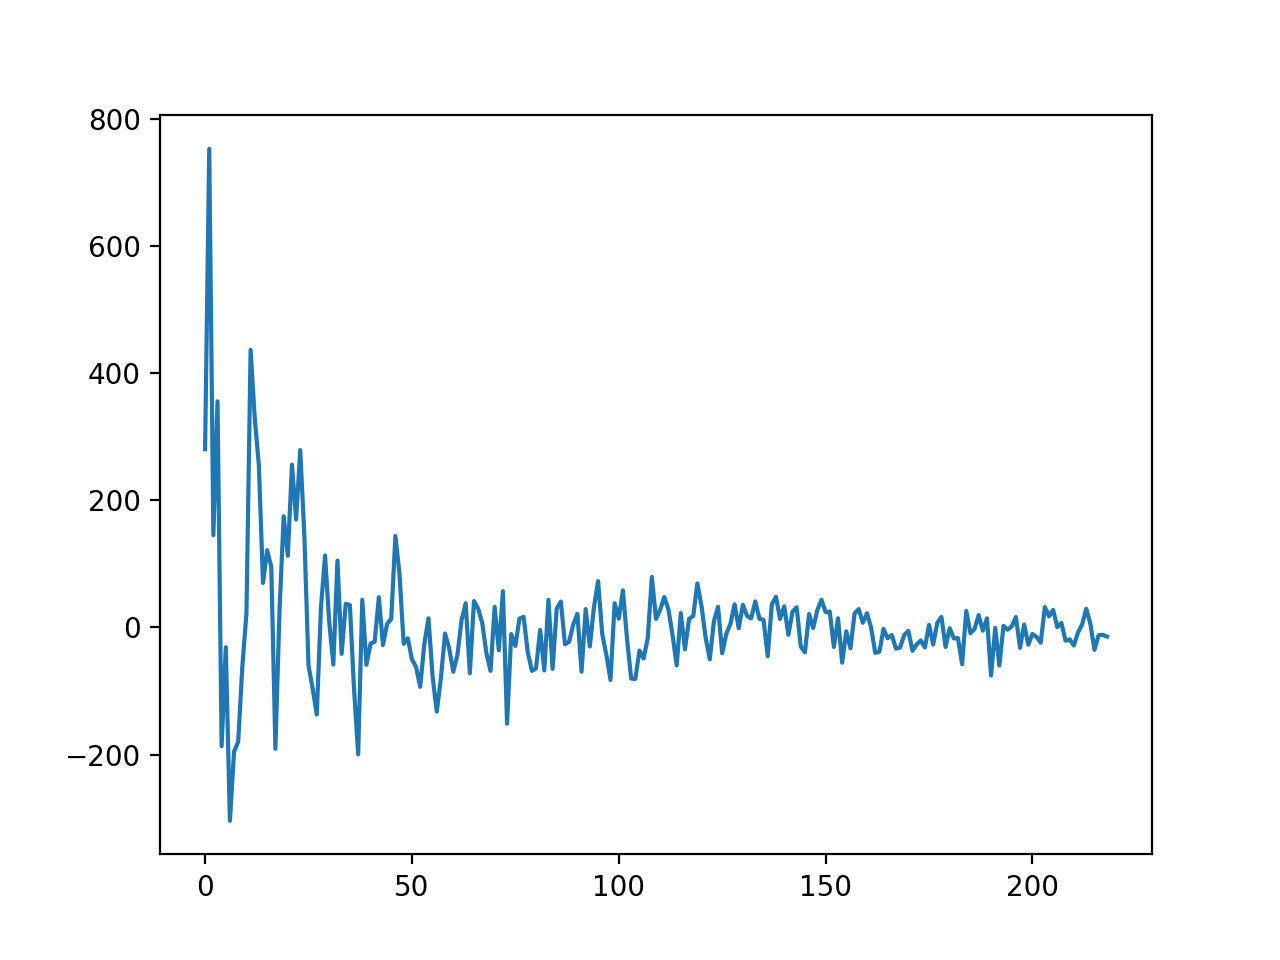

<IPython.core.display.Javascript object>


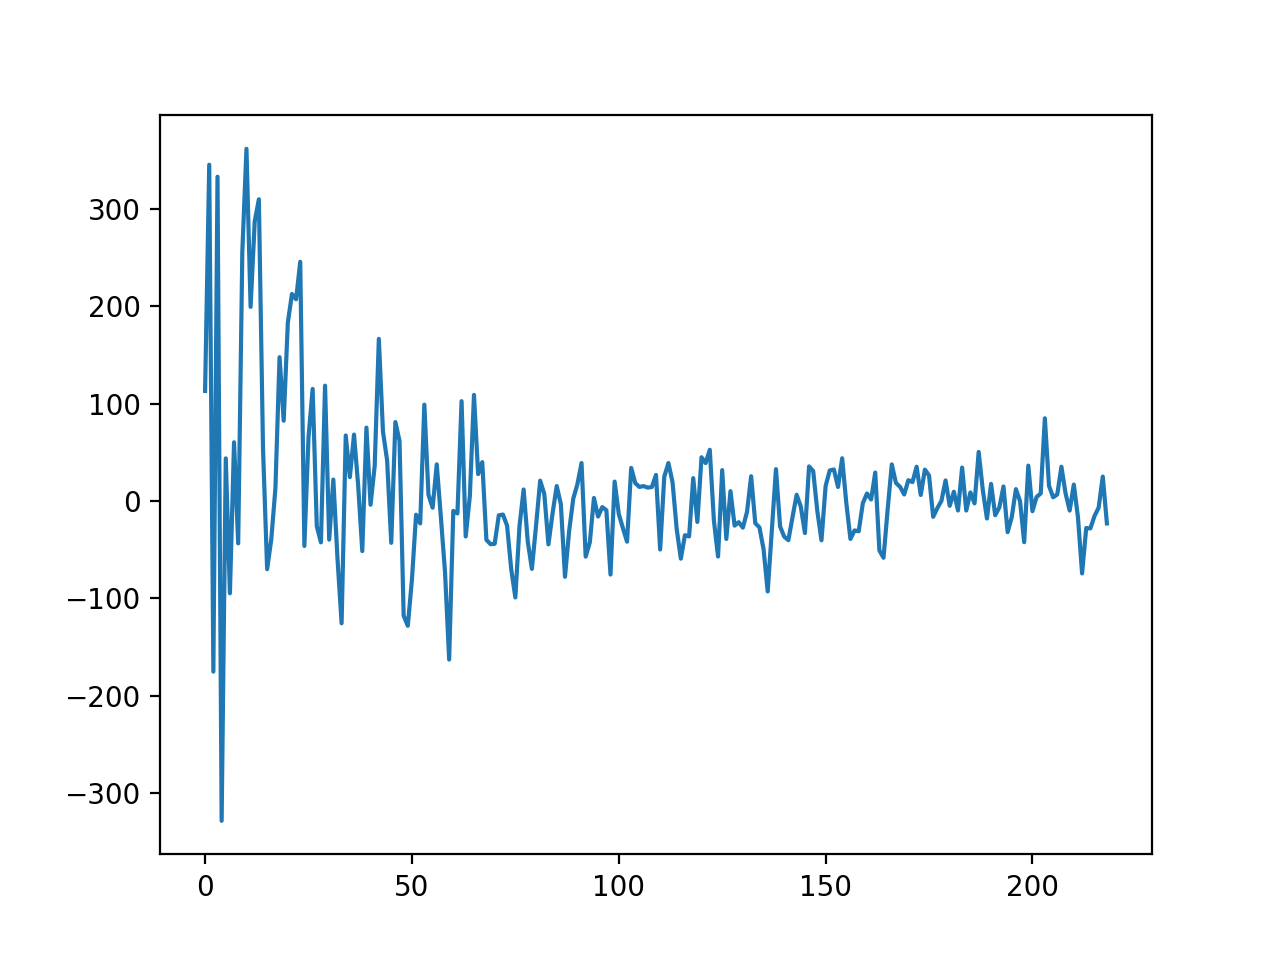

<IPython.core.display.Javascript object>


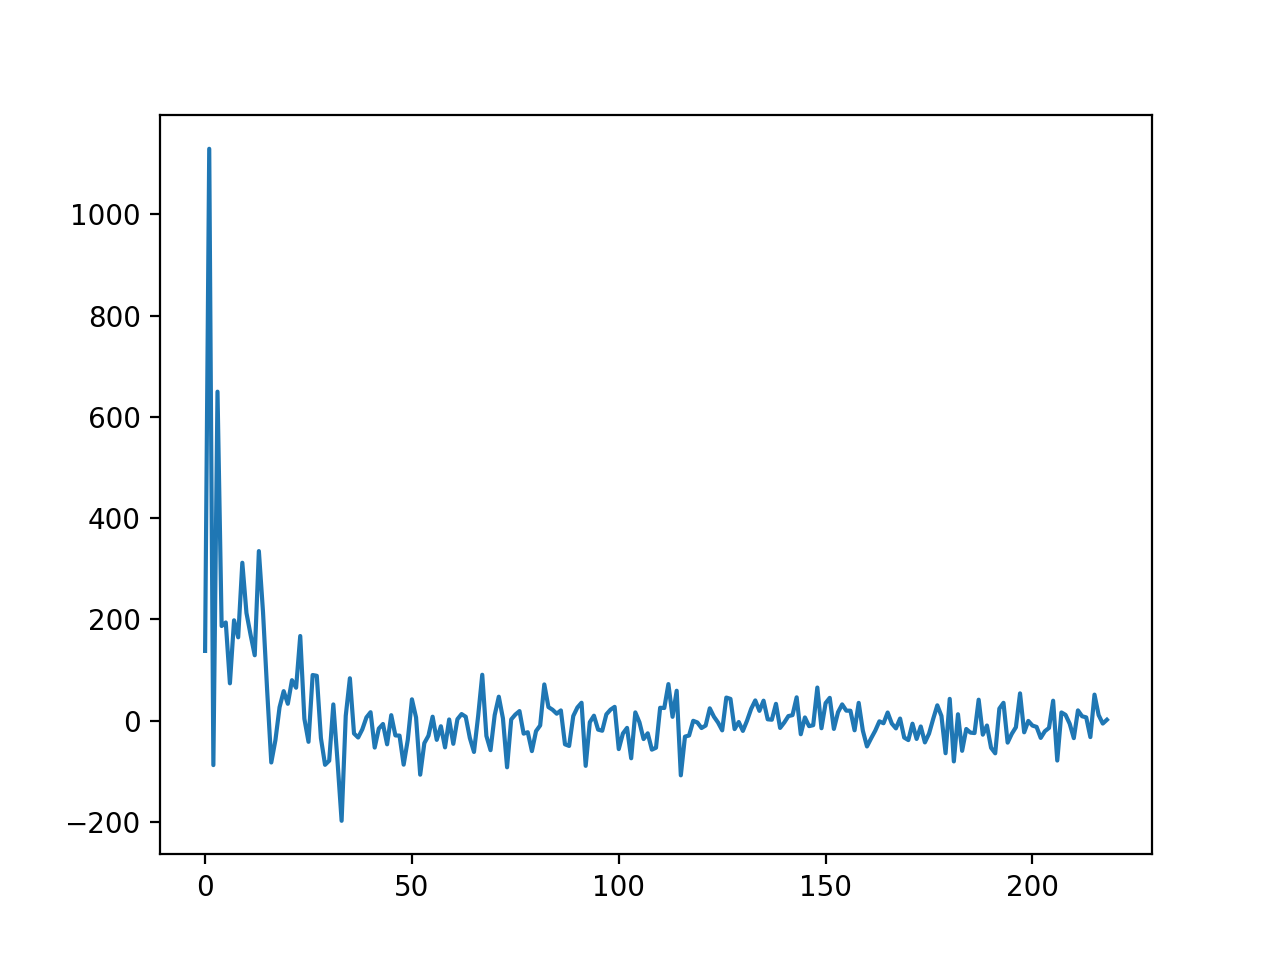

<IPython.core.display.Javascript object>


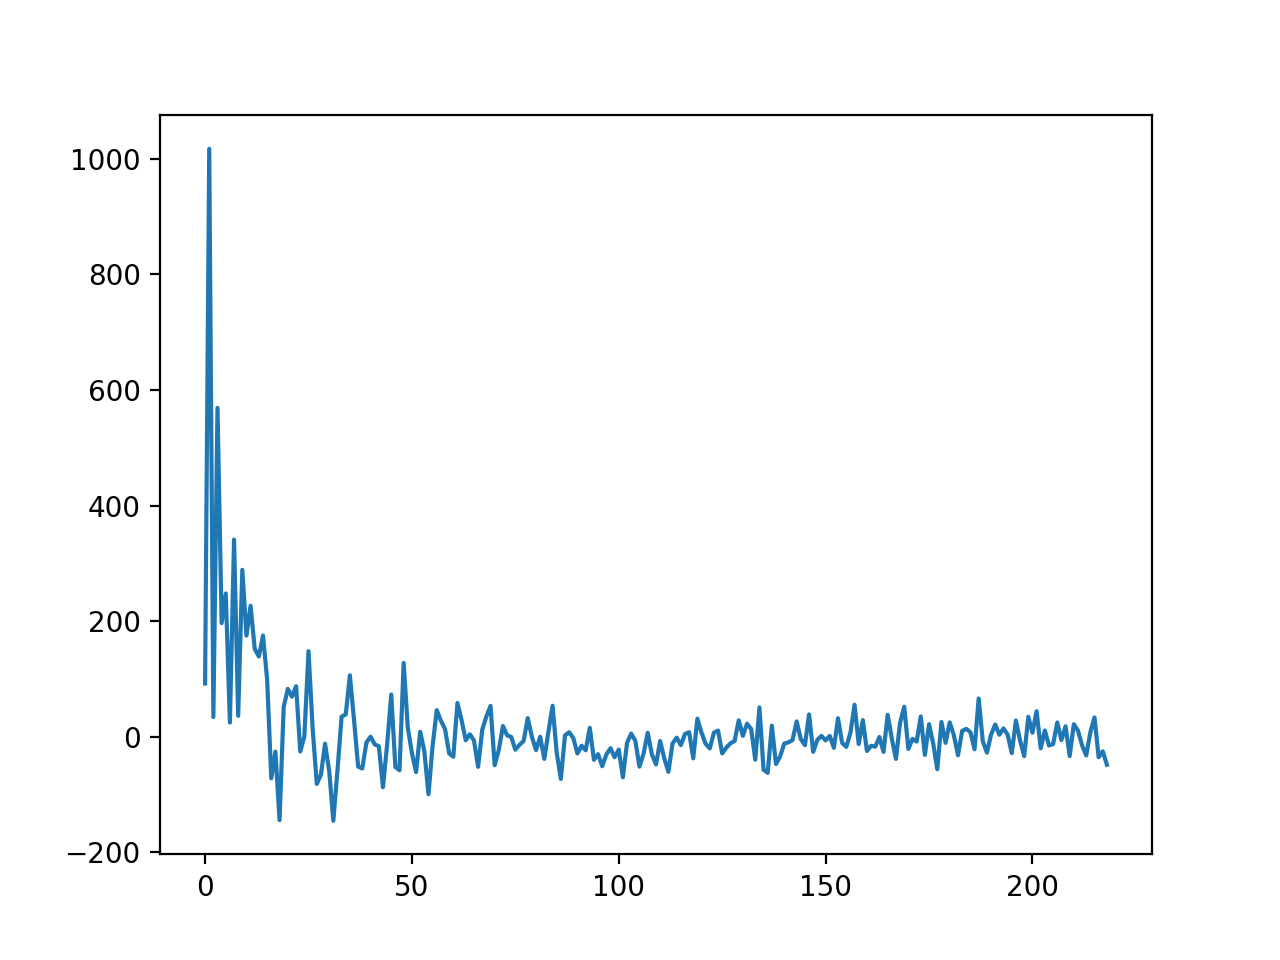

In [83]:
vowels = ["a", "e", "i", "o", "u"]
max_quefrency = 0.005
width = 0.04
overlap = 0.75
cepstra = None
labels = []
nwid = 2

for v in vowels:
    sample_rate, sig = wavfile.read(v + ".wav")
    sig = sig/np.max(np.abs(sig))    

    B = 1
    A = [1, 0.9]
    filtered_sig = signal.filtfilt(B, A, sig)
    windows = Hamming(windowing(filtered_sig, sample_rate, width, overlap))
    E = root_mean_square (windows)
    idx_max = np.argmax(E)
    nb_cc = np.int(np.floor((max_quefrency / width) * windows.shape[1]))
    if cepstra is None:
        cepstra = cepstrum(windows)[idx_max - nwid:idx_max + nwid +1, 1:nb_cc]
    else:
        cepstra = np.vstack((cepstra, cepstrum(windows)[idx_max - nwid:idx_max + nwid +1, 1:nb_cc]))
    labels = labels + [v for i in range(2 * nwid + 1)]
    plt.figure()
    plt.plot(cepstrum(windows)[idx_max, 1:nb_cc])
cepstra = np.array(cepstra)
labels = np.array(labels)

2. Vous devrez maintenant avoir deux nouveaux tableaux dans votre espace de travail, *cepstra* et *labels*. Quelles sont leurs dimensions ?

In [85]:
print(cepstra.shape)
print(labels.shape)

(25, 219)
(25,)


Chaque ligne de la matrice *cepstra* représente une fenêtre du signal dans un espace $\mathbb{R}^n$, où $n$ est le nombre de coefficients cepstraux choisis. Nous pouvons visualisez l'ensemble des points en les projetant dans un sous-espace $\mathbb{R}^2$. Pour cela, nous utiliserons
la technique de l'[Analyse en Composantes Principales](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales), comme ceci :

In [89]:
#np.cov? covariance
#np.vstack? #empile des tableaux verticallement
np.linalg.eig?

<IPython.core.display.Javascript object>


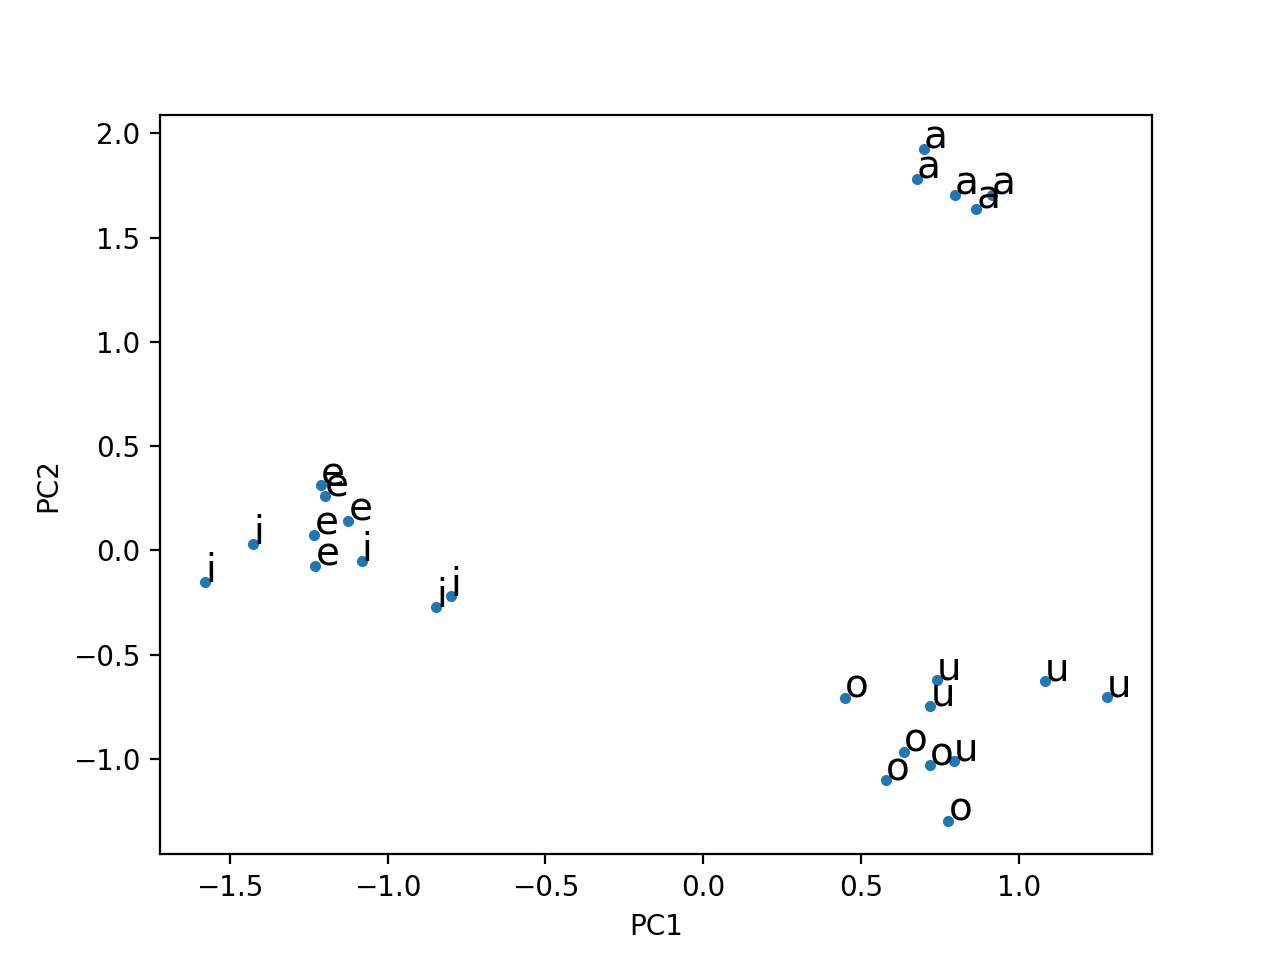

/Users/khadidja/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'PC2')

In [84]:
def pca(x):
    c = np.cov(x.T)
    m0 = np.mean(x, axis=0)
    m = m0.copy()
    for i in range(x.shape[0]-1):
        m = np.vstack((m, m0))
    eigen_values, eigen_vectors = np.linalg.eig(c)
    return (cepstra-m) @ np.real(eigen_vectors) @ np.diag(1/np.sqrt(eigen_values)) 

Y = pca(cepstra)

plt.figure()
plt.plot(Y[:, 0], Y[:, 1], ".")
for i, l in enumerate(labels):
    plt.text(Y [i, 0], Y [i, 1], l, fontsize=14)
plt.xlabel ("PC1")
plt.ylabel ("PC2")

**3. Interprétez le code ci-dessus et le graphique obtenu.**

La fonction permet de visualiser la répartition des voyelles selon leurs caractéristiques acoustiques PC1 et PC2 des coefficients ceptraux. C'est le tableau de delattre en quefrequentiel, nous n'avons plus de formants F1 et F2 mais des PC obtenus par un calcul différent . Ça permet de visualiser les similarités / différences entre les prononciations. Il permet aussi de classer les voyelles et d'après google L'ACP est une des techniques permettant la réduction de dimension, très utile en apprentissage automatique pour améliorer la qualité des modèles, et faciliter leur calcul ce qui doit aider pour les algorithmes de reconnaissances automatique de la parole.